In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mp_api.client import MPRester

from pymatgen.core import Composition, Element
from pymatgen.analysis.phase_diagram import GrandPotentialPhaseDiagram, PhaseDiagram, PDPlotter
from pymatgen.analysis.interface_reactions import InterfacialReactivity, GrandPotentialInterfacialReactivity
from pymatgen.io.vasp import Vasprun
from pymatgen.entries.compatibility import MaterialsProject2020Compatibility
from pymatgen.entries.computed_entries import ComputedEntry
from collections import defaultdict

import re
import sympy as sp




In [2]:
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D



In [3]:
import contextlib
import io, sys
import siman  # program package to manage DFT calculations https://github.com/dimonaks/siman
from siman.calc_manage import smart_structure_read, get_structure_from_matproj
from siman.calc_manage import add, res
from siman import header
from siman.database import write_database, read_database
from siman.set_functions import read_vasp_sets
from siman.header import db
from siman.header import _update_configuration
from pydoc import importfile
from siman import thermo
from matplotlib import rc
import matplotlib.pyplot as plt

# Suppress output (replaces %%capture)
with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    # Update configurations
    _update_configuration('./project_conf.py')
    read_database()  # read saved database if available
    
    project_sets = importfile('./project_sets.py')
    varset = read_vasp_sets(project_sets.user_vasp_sets, override_global=1)  # read user sets

    # Set paths
    # header.PATH2PROJECT = '../dft_calculations/'
    header.PATH2EDITOR = 'notepad.exe'
    header.PATH2POTENTIALS = "/home/a.burov/soft/vasp_potentials/potpaw_PBE_MPIE/"

    # Matplotlib settings (commented out as they're for interactive use)
    plt.rcParams['figure.dpi'] = 450

In [4]:
# polyhedra:
# shiness 100
# V: 229 25 0 204
# P: 192 156 194 204

# Edges: 180



In [5]:
colors_rgb = {
    #  "Li": (179, 222, 195), 
    # "La": (150, 150, 150), 
    # "Zr": (160, 160, 255), 
    # "O": (251, 155, 155), 

    # "Na": (255, 220, 155),
    # "Ga": (252, 170, 224), 
    # "P": (203, 174, 255),
    # "S": (117, 221, 255),
    # "C": (245, 173, 100),
  
    # "B": (1, 1, 1),  
    # "R": (255, 0, 0),  
    #  "N": (101, 83, 176),
    # "K": (255, 142, 185),

    "Na": (249, 220, 60),
    "V": (229, 25, 0),
    "Al": (129, 178, 214),
    "P": (192, 156, 194),
    "O": (254, 3, 0),
    "F": (176, 185, 230),
    "R": (211, 134, 252),
    "N": (227, 187, 102),
    "L": (144, 207, 99),

    "O_dos": (212, 32, 32),
    "V_dos": (85, 139, 204),
    "Al_dos": (98, 200, 199),
    "F_dos": (145, 219, 105),

}





In [6]:
alpha = 0.5
colors_hist = {k: list(float(x)/255 for x in v) + [alpha] for k, v in colors_rgb.items()}
colors_hist = {k: tuple(v)for k, v in colors_hist.items()}

In [7]:
colors_rgb = {element: tuple(v/255 for v in rgb) for element, rgb in colors_rgb.items()}


In [8]:
color_list = [ np.array(color) for name, color in colors_rgb.items() if (name not in ["B", "R"]) ]


In [9]:
colors_num = len(color_list) - 1


In [10]:
def rgb_to_hex(rgb_tuple):
    """Convert an RGB tuple (0-1 range) to a hex string."""
    return "#{:02x}{:02x}{:02x}".format(
        int(rgb_tuple[0] * 255 ),
        int(rgb_tuple[1] * 255 ),
        int(rgb_tuple[2] * 255 )
    )

In [11]:
def blend_with_white(fg_rgb, alpha):
    """
    Blend an RGB color with given alpha over white background.

    Parameters:
        fg_rgb: tuple of (R, G, B), each 0-255
        alpha: float in [0, 1], opacity of foreground color

    Returns:
        tuple of (R, G, B) blended color over white background
    """
    bg_rgb = (255, 255, 255)  # white background
    blended = tuple(
        round(alpha * fg_c + (1 - alpha) * bg_c)
        for fg_c, bg_c in zip(fg_rgb, bg_rgb)
    )
    return blended
    

In [12]:
api_key = 'HbSHn48X1CSvBzRa4DOX5E9rhb5Tcc03'

In [13]:
def create_dataframe_from_calc(vasprun_path: str, calc_name: str, if_save: bool) -> None:
    """
        Inputs:
            vasprun_path - path to vasprun.xml
            calc_name - name to save a file
            if_save - save pandas dataframe as csv
        Returns:
            pandasDataframe - dataframe with the results
    """

    # Extraction of the calculation
    vasprun = Vasprun(vasprun_path)    
    # include structure so proper correction can be applied for oxides and sulfides
    reactant2 = vasprun.get_computed_entry(inc_structure=True)
    # reactant2.parameters['run_type'] = 'GGA+U'
    
    compatibility = MaterialsProject2020Compatibility()
    # compatibility.process_entry(reactant2)
    reactant2 = compatibility.process_entry(reactant2)

    reactant2.parameters['run_type'] = 'GGA_GGA+U'
    # reactant2.parameters['run_type'] = 'GGA+U'
    # reactant2.parameters['run_type'] = 'GGA+U'

    # Find coatings 
    comps = []
    emins = []
    reactions = []
    
    with MPRester(api_key=api_key) as mpr:
        for comp in tqdm(cathode_coatings.formula_pretty.unique()):
            try:
                # Is the system open to an elemental reservoir?
                grand = False
    
                if grand:
                    # Element in the elemental reservoir.
                    open_el = "Na" 
                    # Relative chemical potential vs. pure substance. Must be non-positive.
                    relative_mu = 3.25 # average intercalation potential
    
    
                # Get the compositions of the reactants
                reactant1 = comp
    
                comp1 = Composition(reactant1)
                comp2 = reactant2.composition # as it is manually calculated phase
    
                # Gather all elements involved in the chemical system.
                # elements = [e.symbol for e in comp1.elements + comp2.elements]
                elements = [e.symbol for e in comp1.elements + comp2.elements]
                
                if grand:
                    elements.append(open_el)
                elements = list(set(elements))  # Remove duplicates
    
                entries = mpr.get_entries_in_chemsys(elements, additional_criteria={'thermo_types': ['GGA_GGA+U', "R2SCAN"]})

                # Apply corrections locally with the mixing scheme
                scheme = MaterialsProjectDFTMixingScheme()
                corrected_entries = scheme.process_entries(entries)
    
                # Build a phase diagram using these entries.
                phase_diagram = PhaseDiagram(entries)
    
                # For an open system, include the grand potential phase diagram.
                if grand:
                    # Get the chemical potential of the pure subtance.
                    mu = phase_diagram.get_transition_chempots(Element(open_el))[0]
                    # Set the chemical potential in the elemental reservoir.
                    chempots = {open_el: relative_mu + mu}
                    # Build the grand potential phase diagram
                    gpd = GrandPotentialPhaseDiagram(entries, chempots)
                    # Create InterfacialReactivity object.
                    interface = GrandPotentialInterfacialReactivity(
                        comp1,
                        comp2,
                        gpd,
                        norm=True,
                        # include_no_mixing_energy=True,
                        include_no_mixing_energy=False,
                        pd_non_grand=phase_diagram,
                        use_hull_energy=True,
                    )
                    
                else:
                    interface = InterfacialReactivity(
                        comp1,
                        comp2,
                        phase_diagram,
                        norm=True,
                        include_no_mixing_energy=False,
                        # include_no_mixing_energy=False,
                        pd_non_grand=None,
                        use_hull_energy=True,
                    )
                    
                interface_table = interface.get_dataframe()
                emins.append(interface.get_dataframe()['E$_{\textrm{rxn}}$ (eV/atom)'].min())
                comps.append(comp)
                index = np.argmin(interface_table['E$_{\textrm{rxn}}$ (eV/atom)'].values)
                reactions.append(interface_table['Reaction'].iloc[index])
            except:
                continue

    res = pd.DataFrame()
    res['formula_pretty'] = comps
    res[f'e_rxn_{calc_name}_CC'] = emins
    res[f'interface_reaction_{calc_name}'] = reactions

    if if_save:
        res.merge(cathode_coatings).round(3).to_csv(f'data_nmc/{calc_name}_CC_calculation_results.csv', index = False)
        
    return res
    
    
    


In [14]:
# Path to vasprun.xml file
vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_inter.xml"



In [15]:
# Parse vasprun.xml
vasprun = Vasprun(vasprun_path)

# Get final energy
final_energy = vasprun.final_energy
print(f"Final energy: {final_energy} eV")


Final energy: -905.02190536 eV eV


/home/arseniy/micromamba/envs/default/lib/python3.12/site-packages/pymatgen/io/vasp/outputs.py:1256: UserWarning: No POTCAR file with matching TITEL fields was found in

  if potcar := self.get_potcars(path):
/home/arseniy/micromamba/envs/default/lib/python3.12/site-packages/pymatgen/io/vasp/outputs.py:1274: UserWarning: No POTCAR file with matching TITEL fields was found in

  potcar = self.get_potcars(path)


In [ ]:
vasprun.final_structure.num_sites

In [ ]:
# Access the structure
structure = vasprun.final_structure
# print(structure)


## Thermodynamic stability

In [16]:
from pymatgen.entries.compatibility import MaterialsProjectCompatibility


In [17]:
def balance_reaction_one_reactant_any_products(reactants, products):
    # Get the single reactant name and atom counts
    reactant_name = next(iter(reactants))
    reactant_counts = reactants[reactant_name]

    # Collect unique elements from reactant and all products
    elements = sorted(set(reactant_counts.keys()).union(
        el for p in products.values() for el in p.keys()
    ))

    # Create sympy variables: one for reactant 'a' and one for each product
    a = sp.symbols('a')
    product_vars = sp.symbols(f'b0:{len(products)}')

    # Build balance equations for each element
    equations = []
    for el in elements:
        lhs = a * reactant_counts.get(el, 0)  # reactant side
        rhs = sum(product_vars[i] * p.get(el, 0) for i, p in enumerate(products.values()))
        equations.append(sp.Eq(lhs, rhs))

    # Solve for product coefficients in terms of 'a'
    vars_to_solve = list(product_vars)
    solutions = sp.solve(equations, vars_to_solve, dict=True)
    if not solutions:
        raise ValueError("No solution found to balance the equation.")
    sol = solutions[0]
    sol[a] = a  # keep 'a' free

    # Substitute a=1 to get numeric coefficients
    coeffs = {a: 1}
    coeffs.update({var: sol[var].subs(a, 1) for var in product_vars})

    # Normalize coefficients to smallest integers
    def to_int_fraction(x):
        if isinstance(x, int):
            return x, 1
        else:
            p, q = x.as_numer_denom()
            return int(p), int(q)

    nums_dens = [to_int_fraction(v) for v in coeffs.values()]
    from math import gcd
    from functools import reduce

    def lcm(x, y):
        return x * y // gcd(x, y)

    common_den = reduce(lcm, (d for _, d in nums_dens), 1)
    scaled = [n * (common_den // d) for n, d in nums_dens]
    gcd_all = reduce(gcd, scaled)
    normalized = [s // gcd_all for s in scaled]

    # Prepare output dictionary with species names and their coefficients
    balanced_coeffs = {reactant_name: normalized[0]}
    for i, pname in enumerate(products):
        balanced_coeffs[pname] = normalized[i + 1]

    return balanced_coeffs



In [18]:
def parse_formula(formula):
    pattern = r'([A-Z][a-z]?)(\d*)|(\()|(\))(\d*)'
    matches = list(re.finditer(pattern, formula))
    
    stack = [defaultdict(int)]
    
    for match in matches:
        element, count, open_paren, close_paren, paren_count = match.groups()
        
        if element:
            cnt = int(count) if count else 1
            stack[-1][element] += cnt
        
        elif open_paren:
            stack.append(defaultdict(int))
        
        elif close_paren:
            cnt = int(paren_count) if paren_count else 1
            group = stack.pop()
            for elem, num in group.items():
                stack[-1][elem] += num * cnt
    
    return dict(stack.pop())




In [26]:
# Path to vasprun.xml file
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_inter.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_deinter.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_some_na.xml"

# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al_some_na.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al_some_na_dead.xml"

# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al_li.xml"


# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/al_li_pos1.vasprun"
vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/al_li_pos2.vasprun"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/al_li_pos3.vasprun"




In [27]:
# Parse vasprun.xml
vasprun = Vasprun(vasprun_path)

# Get final energy
final_energy = vasprun.final_energy
print(f"Final energy: {final_energy} eV")


Final energy: -897.13396258 eV eV


/tmp/ipykernel_5135/4184352472.py:2: UnconvergedVASPWarning: /home/arseniy/Desktop/work/nvpf_al_doped/data/stability/al_li_pos2.vasprun is an unconverged VASP run.
Electronic convergence reached: True.
Ionic convergence reached: False.
  vasprun = Vasprun(vasprun_path)


In [28]:
comp_entry = ComputedEntry(vasprun.final_structure.composition, vasprun.final_energy)


In [29]:
elements = [el.symbol for el in comp_entry.elements]  # elements in your compound

with MPRester(api_key) as mpr:
    entries = mpr.get_entries_in_chemsys(elements)  # all known phases in this system

    

Retrieving ThermoDoc documents:   0%|          | 0/1365 [00:00<?, ?it/s]

In [30]:
compat = MaterialsProjectCompatibility()
# MaterialsProject2020Compatibility
entries = compat.process_entries(entries)

# Also process your entry with the same corrections
# entry = compat.process_entry(comp_entry)


/tmp/ipykernel_5135/992659018.py:1: DeprecationWarning: MaterialsProjectCompatibility is deprecated; use MaterialsProject2020Compatibility instead.
Materials Project formation energies use the newer MaterialsProject2020Compatibility scheme.
  compat = MaterialsProjectCompatibility()


In [31]:
st_names = {
        "mp-1238774": 'navpo4f',
        # "mp-25440": 'vpo4f',     
        "mp-686540": 'na3al2p2o8f3',     
        "mp-7848": 'alpo4',     
        "mp-19291": 'navpo5',     
        "mp-468": 'alf3',     
        "mp-559931": 'vf3',     
        "mp-1094113": 'NaV2P2O9',     
        "mp-1104878": 'VPO4F',     
        "mp-17999": 'NaVF4',     
        "mp-752810": 'NaVP2O7',     
        "mp-694937": 'Na3V2P2O8F3',     
        "mp-18835": 'VPO4',     
        "mp-25265": 'VPO5',     
        "mp-26728": 'VP2O7',     
        "mp-1102077": 'NaAlF4',     
       }


In [32]:
all_entries = entries + [comp_entry]
pd = PhaseDiagram(all_entries)

decomp, e_above_hull = pd.get_decomp_and_e_above_hull(comp_entry)

reactants = {vasprun.final_structure.reduced_formula: parse_formula(vasprun.final_structure.reduced_formula)}
reactant_name = next(iter(reactants))
reactant_at = sum(reactants[reactant_name].values())

products = {}

print(f"Energy above hull: {e_above_hull:.4f} eV/atom")
if e_above_hull == 0:
    print("Phase is thermodynamically stable")
elif e_above_hull < 0.05:
    print("Phase is metastable")
else:
    print("Phase decomposes to:")
    for entry, amount in decomp.items():
        mp_id = getattr(entry, "entry_id", "N/A")
        products[entry.composition.reduced_formula] = parse_formula(entry.composition.reduced_formula)
        print(f"{amount:.3f}*{entry.composition.reduced_formula} + ", end="")

    bal = balance_reaction_one_reactant_any_products(reactants, products)
    
    print()
    coeff_react = bal[reactant_name]
    en_decomp = (vasprun.final_energy / vasprun.final_structure.num_sites) * reactant_at * coeff_react
    for entry, amount in decomp.items():
        mp_id = getattr(entry, "entry_id", "N/A")
        mp_id_parse = mp_id.split('-GGA')[0]
        react_name = entry.composition.reduced_formula
        coeff_prod = bal[react_name]
        name_calc = st_names[mp_id_parse]
        en_react = db[name_calc, '9_bulk_mp', 1].e0_at
        product_at = sum(products[entry.composition.reduced_formula].values())
        en_decomp -= en_react * product_at * coeff_prod
        print(f"  {entry.composition.reduced_formula} (MP-ID: {mp_id}) : {amount:.3f}")

    print()
    
    for entry, amount in decomp.items():
        mp_id = getattr(entry, "entry_id", "N/A")
        mp_id_parse = mp_id.split('-GGA')[0]
        react_name = entry.composition.reduced_formula
        coeff_prod = bal[react_name]
        name_calc = st_names[mp_id_parse]
        en_react = db[name_calc, '9_bulk_mp', 1].e0_at
        product_at = sum(products[entry.composition.reduced_formula].values())
        print(f"{amount:.3f}*{mp_id_parse} + ", end="")

    print()

    en_decomp /= (reactant_at * coeff_react)
    # en_decomp /= (reactant_at)
    
    print(f"Decomposition energy is {en_decomp*1000:.0f} meV/atom")

        

Energy above hull: 0.4061 eV/atom
Phase decomposes to:
0.571*Na3V2P2O8F3 + 0.048*NaAlF4 + 0.381*VPO4 + 
  Na3V2P2O8F3 (MP-ID: mp-694937-GGA+U) : 0.571
  NaAlF4 (MP-ID: mp-1102077-GGA) : 0.048
  VPO4 (MP-ID: mp-18835-GGA+U) : 0.381

0.571*mp-694937 + 0.048*mp-1102077 + 0.381*mp-18835 + 
Decomposition energy is 32 meV/atom


In [33]:
coeff_react

1

In [34]:
bal


{'Na13AlV16P16(O4F)16': 1, 'Na3V2P2O8F3': 4, 'NaAlF4': 1, 'VPO4': 8}

In [35]:
coeff_react

1

## RDF

In [168]:
from ovito.io import import_file
from ovito.modifiers import CoordinationAnalysisModifier, VoronoiAnalysisModifier, SelectTypeModifier
from ovito.data import DataCollection  # Or your pipeline's compute output type




In [169]:
def calculate_average_rdf(pipeline, li_type_id=1, o_type_id=4, cutoff=7.0, number_of_bins=200):
    """Calculate average RDF and standard deviation across all frames"""
    # Initialize storage
    all_li_o_rdf = []
    all_li_li_rdf = []
    distances = None
    
    # Process each frame
    for frame in tqdm(range(pipeline.source.num_frames), desc="Processing frames"):
        pipeline.modifiers.clear()
        
        # Select only Li and O atoms
        pipeline.modifiers.append(SelectTypeModifier(
            property='Particle Type',
            types={li_type_id, o_type_id}
        ))
        
        # RDF analysis
        pipeline.modifiers.append(CoordinationAnalysisModifier(
            cutoff=cutoff,
            number_of_bins=number_of_bins,
            partial=True
        ))
        
        data = pipeline.compute(frame)
        rdf_table = data.tables['coordination-rdf']
        xy_data = rdf_table.xy()
        component_names = rdf_table.y.component_names
        
        # Store distances (same for all frames)
        if distances is None:
            distances = xy_data[:, 0]
        
        # Extract Li-O and Li-Li RDFs
        li_o_rdf = None
        li_li_rdf = None
        
        for i, name in enumerate(component_names):
            if name == f"{li_type_id}-{o_type_id}" or name == f"{o_type_id}-{li_type_id}":
                li_o_rdf = xy_data[:, i+1]
            elif name == f"{li_type_id}-{li_type_id}":
                li_li_rdf = xy_data[:, i+1]
        
        if li_o_rdf is not None:
            all_li_o_rdf.append(li_o_rdf)
        if li_li_rdf is not None:
            all_li_li_rdf.append(li_li_rdf)
    
    # Convert to numpy arrays
    li_o_rdfs = np.array(all_li_o_rdf)
    li_li_rdfs = np.array(all_li_li_rdf)
    
    # Calculate statistics
    results = {
        'Li-O': {
            'distances': distances,
            'mean': np.mean(li_o_rdfs, axis=0),
            'std': np.std(li_o_rdfs, axis=0),
            'all': li_o_rdfs
        },
        'Li-Li': {
            'distances': distances,
            'mean': np.mean(li_li_rdfs, axis=0),
            'std': np.std(li_li_rdfs, axis=0),
            'all': li_li_rdfs
        }
    }
    
    return results

def print_top_peaks(rdf_results, n_peaks=5):
    """Print positions and intensities of top RDF peaks with errors"""
    for correlation in ['Li-O', 'Li-Li']:
        print(f"\nTop {n_peaks} peaks for {correlation}:")
        print("-"*50)
        print(f"{'Peak':<10}{'Position (Å)':<15}{'Intensity':<15}{'± Error':<15}")
        print("-"*50)
        
        distances = rdf_results[correlation]['distances']
        mean_rdf = rdf_results[correlation]['mean']
        std_rdf = rdf_results[correlation]['std']
        
        # Find peaks (adjust prominence as needed)
        peaks, properties = find_peaks(mean_rdf, prominence=0.5)
        
        # Sort peaks by intensity (descending)
        sorted_peaks = sorted(zip(peaks, mean_rdf[peaks]), 
                            key=lambda x: x[1], reverse=True)
        
        # Print top n peaks
        for i, (peak_idx, intensity) in enumerate(sorted_peaks[:n_peaks]):
            pos = distances[peak_idx]
            error = std_rdf[peak_idx]
            print(f"{i+1:<10}{pos:<15.3f}{intensity:<15.3f}{error:<15.3f}")





In [170]:
def calculate_average_rdf(pipeline, frame=0, v_type_id=2, o_type_id=4, f_type_id=5, cutoff=7.0, number_of_bins=200):
    all_v_o_rdfs = []
    all_v_f_rdfs = []
    all_v_o_f_rdfs = []
    distances = None
    pipeline.modifiers.clear()
    # Select only V, O, and F atoms
    pipeline.modifiers.append(SelectTypeModifier(
        property='Particle Type',
        types={v_type_id, o_type_id, f_type_id}
    ))
    # RDF calculation modifier
    pipeline.modifiers.append(CoordinationAnalysisModifier(
        cutoff=cutoff,
        number_of_bins=number_of_bins,
        partial=True
    ))

    for frame in range(pipeline.num_frames):
        # print(frame)
        data = pipeline.compute(frame)
        rdf_table = data.tables['coordination-rdf']
        xy_data = rdf_table.xy()
        component_names = rdf_table.y.component_names
        
        if distances is None:
            distances = xy_data[:, 0]
        
        v_o_rdf = None
        v_f_rdf = None
    
        for i, name in enumerate(component_names):
            if name == 'V-O' or name == 'O-V':
                v_o_rdf = xy_data[:, i+1]
            elif name == 'V-F' or name == 'F-V':
                v_f_rdf = xy_data[:, i+1]
        
        # Calculate total RDF as sum of V-O and V-F
        v_o_f_rdf = None
        if v_o_rdf is not None and v_f_rdf is not None:
            v_o_f_rdf = v_o_rdf + v_f_rdf
        elif v_o_rdf is not None:
            v_o_f_rdf = v_o_rdf.copy()
        elif v_f_rdf is not None:
            v_o_f_rdf = v_f_rdf.copy()
    
        if v_o_rdf is not None:
            all_v_o_rdfs.append(v_o_rdf)
        if v_f_rdf is not None:
            all_v_f_rdfs.append(v_f_rdf)
        if v_o_f_rdf is not None:
            all_v_o_f_rdfs.append(v_o_f_rdf)
    
    import numpy as np
    
    results = {}
    if all_v_o_f_rdfs:
        v_o_f_rdfs_array = np.array(all_v_o_f_rdfs)
        results['V-O+V-F'] = {
            'distances': distances,
            'mean': np.mean(v_o_f_rdfs_array, axis=0),
            'std': np.std(v_o_f_rdfs_array, axis=0),
            'all': v_o_f_rdfs_array
        }
    if all_v_o_rdfs:
        v_o_rdfs_array = np.array(all_v_o_rdfs)
        results['V-O'] = {
            'distances': distances,
            'mean': np.mean(v_o_rdfs_array, axis=0),
            'std': np.std(v_o_rdfs_array, axis=0),
            'all': v_o_rdfs_array
        }
    if all_v_f_rdfs:
        v_f_rdfs_array = np.array(all_v_f_rdfs)
        results['V-F'] = {
            'distances': distances,
            'mean': np.mean(v_f_rdfs_array, axis=0),
            'std': np.std(v_f_rdfs_array, axis=0),
            'all': v_f_rdfs_array
        }
    

    
    return results


In [171]:
# Usage example:
# pipeline_inter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/inter.POSCAR")
pipeline_inter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/inter.XDATCAR")
results_inter = calculate_average_rdf(pipeline_inter)

# pipeline_deinter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/some_na.POSCAR")
pipeline_deinter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/deinter.XDATCAR")
results_deinter = calculate_average_rdf(pipeline_deinter)

# pipeline_al_inter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_dist.POSCAR")
pipeline_al_inter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al.dist.XDATCAR")
results_al_inter = calculate_average_rdf(pipeline_al_inter)

# pipeline_al_deinter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_some_na_dead.POSCAR")
pipeline_al_deinter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al_some_na.XDATCAR")
results_al_deinter = calculate_average_rdf(pipeline_al_deinter)

In [172]:
# results_al_inter

In [173]:
# Print statistics
print("\nRDF Statistics Low:")
print(f"V-O average first peak height: {np.max(results_inter['V-O']['mean']):.2f}")
print(f"F-O average first peak height: {np.max(results_inter['V-F']['mean']):.2f}")



RDF Statistics Low:
V-O average first peak height: 10.66
F-O average first peak height: 18.75


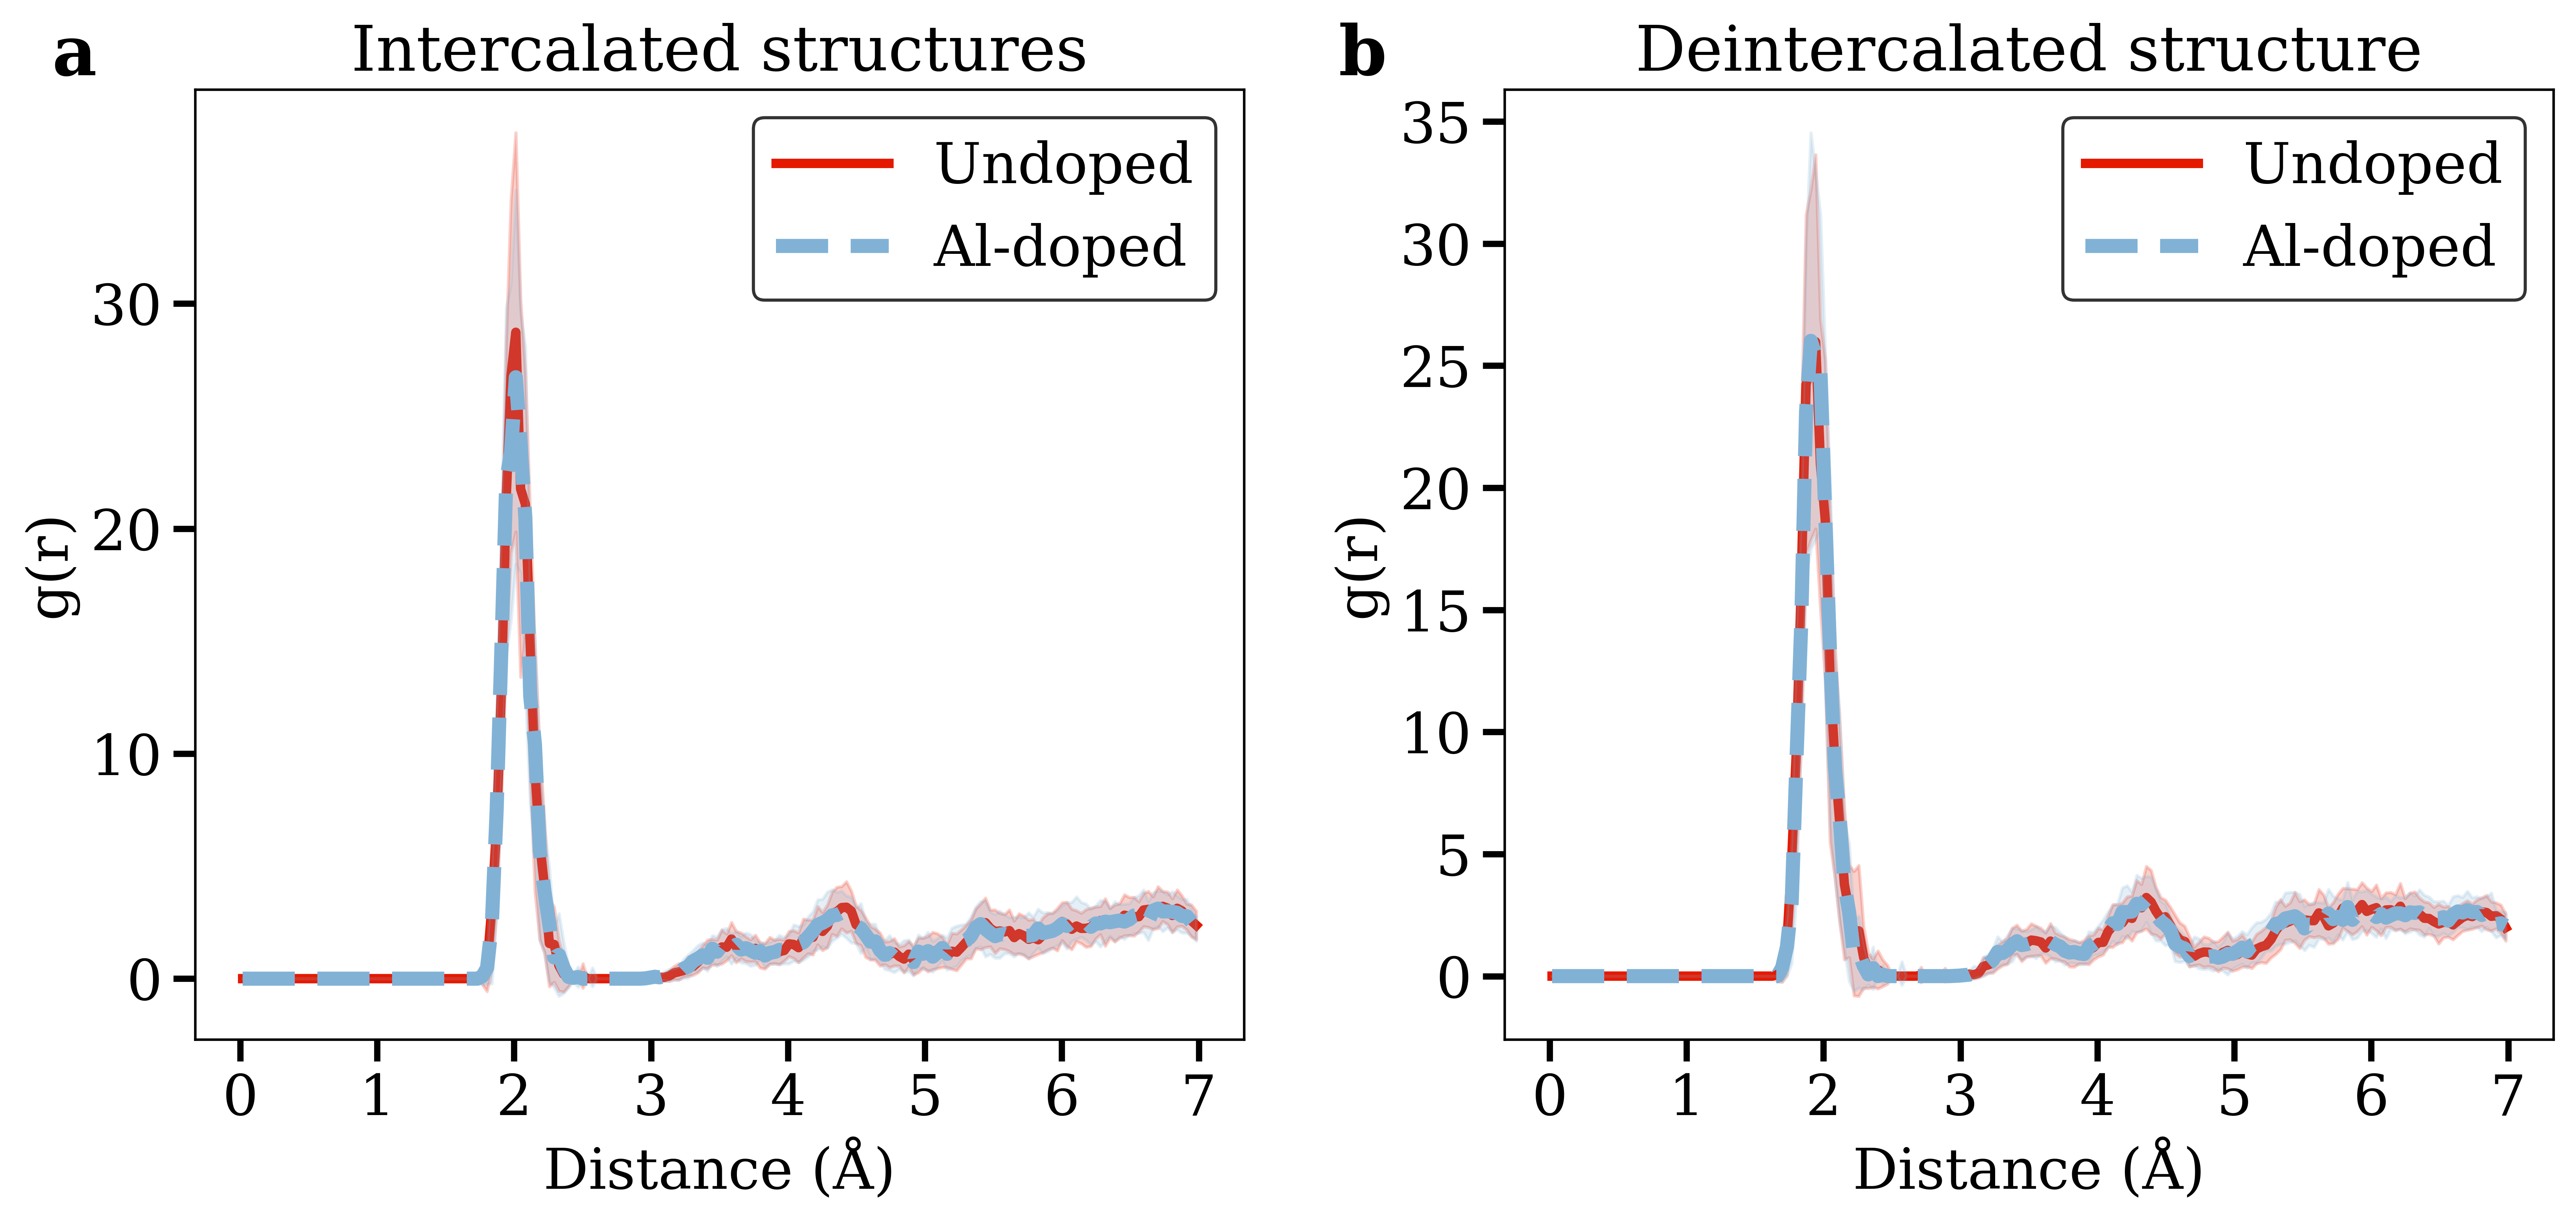

In [188]:
fontsize = 18
lw = 3.0
alpha = 0.20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=600)
plt.tight_layout()

# --- V-O subplot ---
dist_inter = results_inter['V-O+V-F']['distances']
mean_inter = results_inter['V-O+V-F']['mean']
std_inter = results_inter['V-O+V-F']['std']

dist_deinter = results_deinter['V-O+V-F']['distances']
mean_deinter = results_deinter['V-O+V-F']['mean']
std_deinter = results_deinter['V-O+V-F']['std']

dist_al_inter = results_al_inter['V-O+V-F']['distances']
mean_al_inter = results_al_inter['V-O+V-F']['mean']
std_al_inter = results_al_inter['V-O+V-F']['std']

dist_al_deinter = results_al_deinter['V-O+V-F']['distances']
mean_al_deinter = results_al_deinter['V-O+V-F']['mean']
std_al_deinter = results_al_deinter['V-O+V-F']['std']

ax1.plot(dist_inter, mean_inter, '-', color=colors_rgb["V"], label=r'Undoped', lw=lw, zorder=1)
ax1.fill_between(dist_inter, mean_inter-std_inter, mean_inter+std_inter, color=colors_rgb["V"], alpha=alpha)

ax1.plot(dist_al_inter, mean_al_inter, '--', color=colors_rgb["Al"], label=r'Al-doped', lw=lw*1.5, zorder=2)
ax1.fill_between(dist_al_inter, mean_al_inter-std_al_inter, mean_al_inter+std_al_inter, color=colors_rgb["Al"], alpha=alpha)

ax1.locator_params(axis='y', nbins=8)
ax1.locator_params(axis='x', nbins=8)
ax1.set_xlabel('Distance (Å)', fontsize=fontsize)
ax1.set_ylabel('g(r)', fontsize=fontsize)
ax1.set_title('Intercalated structures', fontsize=fontsize+2)
ax1.legend(loc=1, fontsize=fontsize, edgecolor="black")
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize-2)
ax1.yaxis.get_offset_text().set_fontsize(10)
ax1.xaxis.set_tick_params(width=2, length=7)
ax1.yaxis.set_tick_params(width=2, length=7)
# ax1.grid(alpha=0.3)


ax2.plot(dist_deinter, mean_deinter, '-', color=colors_rgb["V"], label=r'Undoped', lw=lw, zorder=1)
ax2.fill_between(dist_deinter, mean_deinter-std_deinter, mean_deinter+std_deinter, color=colors_rgb["V"], alpha=alpha)

ax2.plot(dist_al_deinter, mean_al_deinter, '--', color=colors_rgb["Al"], label=r'Al-doped', lw=lw*1.5, zorder=2)
ax2.fill_between(dist_al_deinter, mean_al_deinter-std_al_deinter, mean_al_deinter+std_al_deinter, color=colors_rgb["Al"], alpha=alpha)

ax2.locator_params(axis='y', nbins=8)
ax2.locator_params(axis='x', nbins=8)
ax2.set_xlabel('Distance (Å)', fontsize=fontsize)
ax2.set_ylabel('g(r)', fontsize=fontsize)
ax2.set_title('Deintercalated structure', fontsize=fontsize+2)
ax2.legend(loc=1, fontsize=fontsize, edgecolor="black")
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize-2)
ax2.yaxis.get_offset_text().set_fontsize(10)
ax2.xaxis.set_tick_params(width=2, length=7)
ax2.yaxis.set_tick_params(width=2, length=7)

ax1.text(-0.115, 1.0, "a",  horizontalalignment='center', verticalalignment='center', 
             transform=ax1.transAxes, ha='center', va='bottom', fontsize=fontsize+4, weight=1000)
ax2.text(-0.135, 1.0, "b",  horizontalalignment='center', verticalalignment='center', 
             transform=ax2.transAxes, ha='center', va='bottom', fontsize=fontsize+4, weight=1000)


plt.tight_layout()
plt.show()


fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/ratios.png", dpi=600, bbox_inches='tight')
fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/ratios.pdf", dpi=600, bbox_inches='tight')




In [21]:
def print_top_peaks(rdf_results, n_peaks=5):
    """Print positions and intensities of top RDF peaks with errors"""
    for correlation in ['V-O', 'V-F']:
        print(f"\nTop {n_peaks} peaks for {correlation}:")
        print("-"*50)
        print(f"{'Peak':<10}{'Position (Å)':<15}{'Intensity':<15}{'± Error':<15}")
        print("-"*50)
        
        distances = rdf_results[correlation]['distances']
        mean_rdf = rdf_results[correlation]['mean']
        std_rdf = rdf_results[correlation]['std']
        
        # Find peaks (adjust prominence as needed)
        peaks, properties = find_peaks(mean_rdf, prominence=0.05)
        
        # Sort peaks by intensity (descending)
        sorted_peaks = sorted(zip(peaks, mean_rdf[peaks]), 
                            key=lambda x: x[1], reverse=True)
        
        # Print top n peaks
        for i, (peak_idx, intensity) in enumerate(sorted_peaks[:n_peaks]):
            pos = distances[peak_idx]
            error = std_rdf[peak_idx]
            print(f"{i+1:<10}{pos:<15.3f}{intensity:<15.3f}{error:<15.3f}")

print("Low:")
print_top_peaks(results_low)

print("\n High:")
print_top_peaks(results_high)


Low:


NameError: name 'results_low' is not defined

In [22]:
# Usage example:
pipeline_low = import_file("./data/ga_400.lammpstrj")
results_low = calculate_average_rdf(pipeline_low)

pipeline_high = import_file("./data/ga_1300.lammpstrj")
results_high = calculate_average_rdf(pipeline_high)

# print_top_peaks(results)

# Print statistics
print("\nRDF Statistics Low:")
print(f"Li-O average first peak height: {np.max(results_low['Li-O']['mean']):.2f} ± {results_low['Li-O']['std'][np.argmax(results_low['Li-O']['mean'])]:.2f}")
print(f"Li-Li average first peak height: {np.max(results_low['Li-Li']['mean']):.2f} ± {results_low['Li-Li']['std'][np.argmax(results_low['Li-Li']['mean'])]:.2f}")

print("\nRDF Statistics High:")
print(f"Li-O average first peak height: {np.max(results_high['Li-O']['mean']):.2f} ± {results_high['Li-O']['std'][np.argmax(results_high['Li-O']['mean'])]:.2f}")
print(f"Li-Li average first peak height: {np.max(results_high['Li-Li']['mean']):.2f} ± {results_high['Li-Li']['std'][np.argmax(results_high['Li-Li']['mean'])]:.2f}")



RuntimeError: File does not exist: ./data/ga_400.lammpstrj

## Rotation of polyhedra

In [36]:
import numpy as np
from pymatgen.io.vasp import Poscar
from scipy.spatial.transform import Rotation


In [37]:
import numpy as np
from pymatgen.io.vasp import Poscar
from scipy.spatial.transform import Rotation

def get_polyhedra_bond_vectors(structure, central_element, neighbor_elements, cutoff):
    bond_vectors_list = []
    for site in structure.sites:
        if site.species_string == central_element:
            neighbors = structure.get_neighbors(site, cutoff)
            filtered = [n for n in neighbors if n.species_string in neighbor_elements]
            vectors = np.array([n.coords - site.coords for n in filtered])
            bond_vectors_list.append(vectors)
    return bond_vectors_list

def kabsch_rotation(P, Q):
    assert P.shape == Q.shape, f"Shapes must match: {P.shape} vs {Q.shape}"
    P_centroid = P.mean(axis=0)
    Q_centroid = Q.mean(axis=0)
    P_centered = P - P_centroid
    Q_centered = Q - Q_centroid
    C = Q_centered.T @ P_centered
    V, S, Wt = np.linalg.svd(C)
    d = np.sign(np.linalg.det(V) * np.linalg.det(Wt))
    if d < 0:
        V[:, -1] *= -1
    U = V @ Wt
    return U

def analyze_polyhedra_rotations(reference_poscar, target_poscar, v_element="V", neighbor_elements=["O", "F"], cutoff=2.5):
    ref_struct = Poscar.from_file(reference_poscar).structure
    tgt_struct = Poscar.from_file(target_poscar).structure

    ref_bonds = get_polyhedra_bond_vectors(ref_struct, v_element, neighbor_elements, cutoff)
    tgt_bonds = get_polyhedra_bond_vectors(tgt_struct, v_element, neighbor_elements, cutoff)

    n_ref = len(ref_bonds)
    n_tgt = len(tgt_bonds)
    min_polyhedra = min(n_ref, n_tgt)
    if n_ref != n_tgt:
        print(f"Warning: Number of polyhedra differs (ref: {n_ref}, tgt: {n_tgt}). Comparing first {min_polyhedra} polyhedra.")

    rotations = []
    for i in range(min_polyhedra):
        P = ref_bonds[i]
        Q = tgt_bonds[i]
        if P.shape[0] != Q.shape[0]:
            print(f"Warning: Polyhedron {i} has differing bond counts (ref: {P.shape[0]}, tgt: {Q.shape[0]}). Skipping.")
            continue
        P_norm = P / np.linalg.norm(P, axis=1)[:, None]
        Q_norm = Q / np.linalg.norm(Q, axis=1)[:, None]
        try:
            R = kabsch_rotation(P_norm, Q_norm)
            rot = Rotation.from_matrix(R)
            angle_deg = np.degrees(rot.magnitude())
            axis = rot.as_rotvec() / rot.magnitude() if rot.magnitude() > 0 else np.array([0, 0, 0])
            rotations.append((angle_deg, axis))
            print(f"Polyhedron {i}: rotation angle = {angle_deg:.2f}°, axis = {axis}")
        except AssertionError as e:
            print(f"Error aligning polyhedron {i}: {e}")
    return rotations



In [38]:
# Example usage:
ref_poscar_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/inter.POSCAR"
target_poscar_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_dist.POSCAR"



In [77]:
rotations = analyze_polyhedra_rotations(ref_poscar_path, target_poscar_path, v_element="P", 
                                        neighbor_elements=["O", "F"], cutoff=3.0)  # cutoff in Angstroms


Polyhedron 0: rotation angle = 0.19°, axis = [-0.62258895 -0.16590049 -0.76476142]
Polyhedron 1: rotation angle = 0.21°, axis = [-0.51600483  0.82682486 -0.22382955]
Polyhedron 2: rotation angle = 0.16°, axis = [ 0.88239044 -0.40320119  0.24251994]
Polyhedron 3: rotation angle = 2.92°, axis = [-0.83362869 -0.42626066 -0.35123362]
Polyhedron 4: rotation angle = 2.16°, axis = [ 0.40130445 -0.09955224 -0.91051858]
Polyhedron 5: rotation angle = 0.51°, axis = [-0.77122262 -0.52051471  0.3664425 ]
Polyhedron 6: rotation angle = 2.57°, axis = [0.80155434 0.46006531 0.38190384]
Polyhedron 7: rotation angle = 0.17°, axis = [-0.53387242 -0.24612644 -0.80895118]
Polyhedron 8: rotation angle = 1.99°, axis = [ 0.03362099 -0.36687587  0.92966215]
Polyhedron 9: rotation angle = 0.04°, axis = [-0.80111474 -0.46123642  0.38141335]
Polyhedron 10: rotation angle = 2.92°, axis = [-0.11826186  0.3945538   0.91123072]
Polyhedron 11: rotation angle = 0.11°, axis = [0.82387809 0.50906181 0.24916053]
Polyhedr

## V/V_0 ratios

In [361]:
conc_exp = [1.0, 830.30/832.99, 825.77/832.99]

conc_calc = [1.0, 867.020/876.978]

In [362]:
a_calc = [1, 12.796/12.845]
a_exp = [1, 12.6167/12.6276, 12.6054/12.6276]

In [363]:
b_calc = [1, 6.320/6.344]
b_exp = [1, 6.2246/6.2326, 6.2116/6.2326]

In [364]:
c_calc = [1.0, 10.721/10.762]
c_exp = [1.0, 10.5725/10.5641, 10.5463/10.5641]

In [365]:
ratios_exp = [0, 0.05, 0.1]
ratios_calc = [0, 0.125]



In [366]:
data_plot_exp = [
    a_exp,
    b_exp,
    c_exp,
    conc_exp,
]


In [367]:
data_plot_calc = [
    a_calc,
    b_calc,
    c_calc,
    conc_calc,
]


In [368]:
labels = [
    r'$a/a_{0}$',
    r'$b/b_{0}$',
    r'$c/c_{0}$',
    r'$V/V_{0}$',
]


In [369]:
colors = [
    'r',
    'g',    
    'b',    
    'black',    
]



In [370]:
data_plot_exp[2]

[1.0, 1.0007951458240645, 0.9983150481347205]

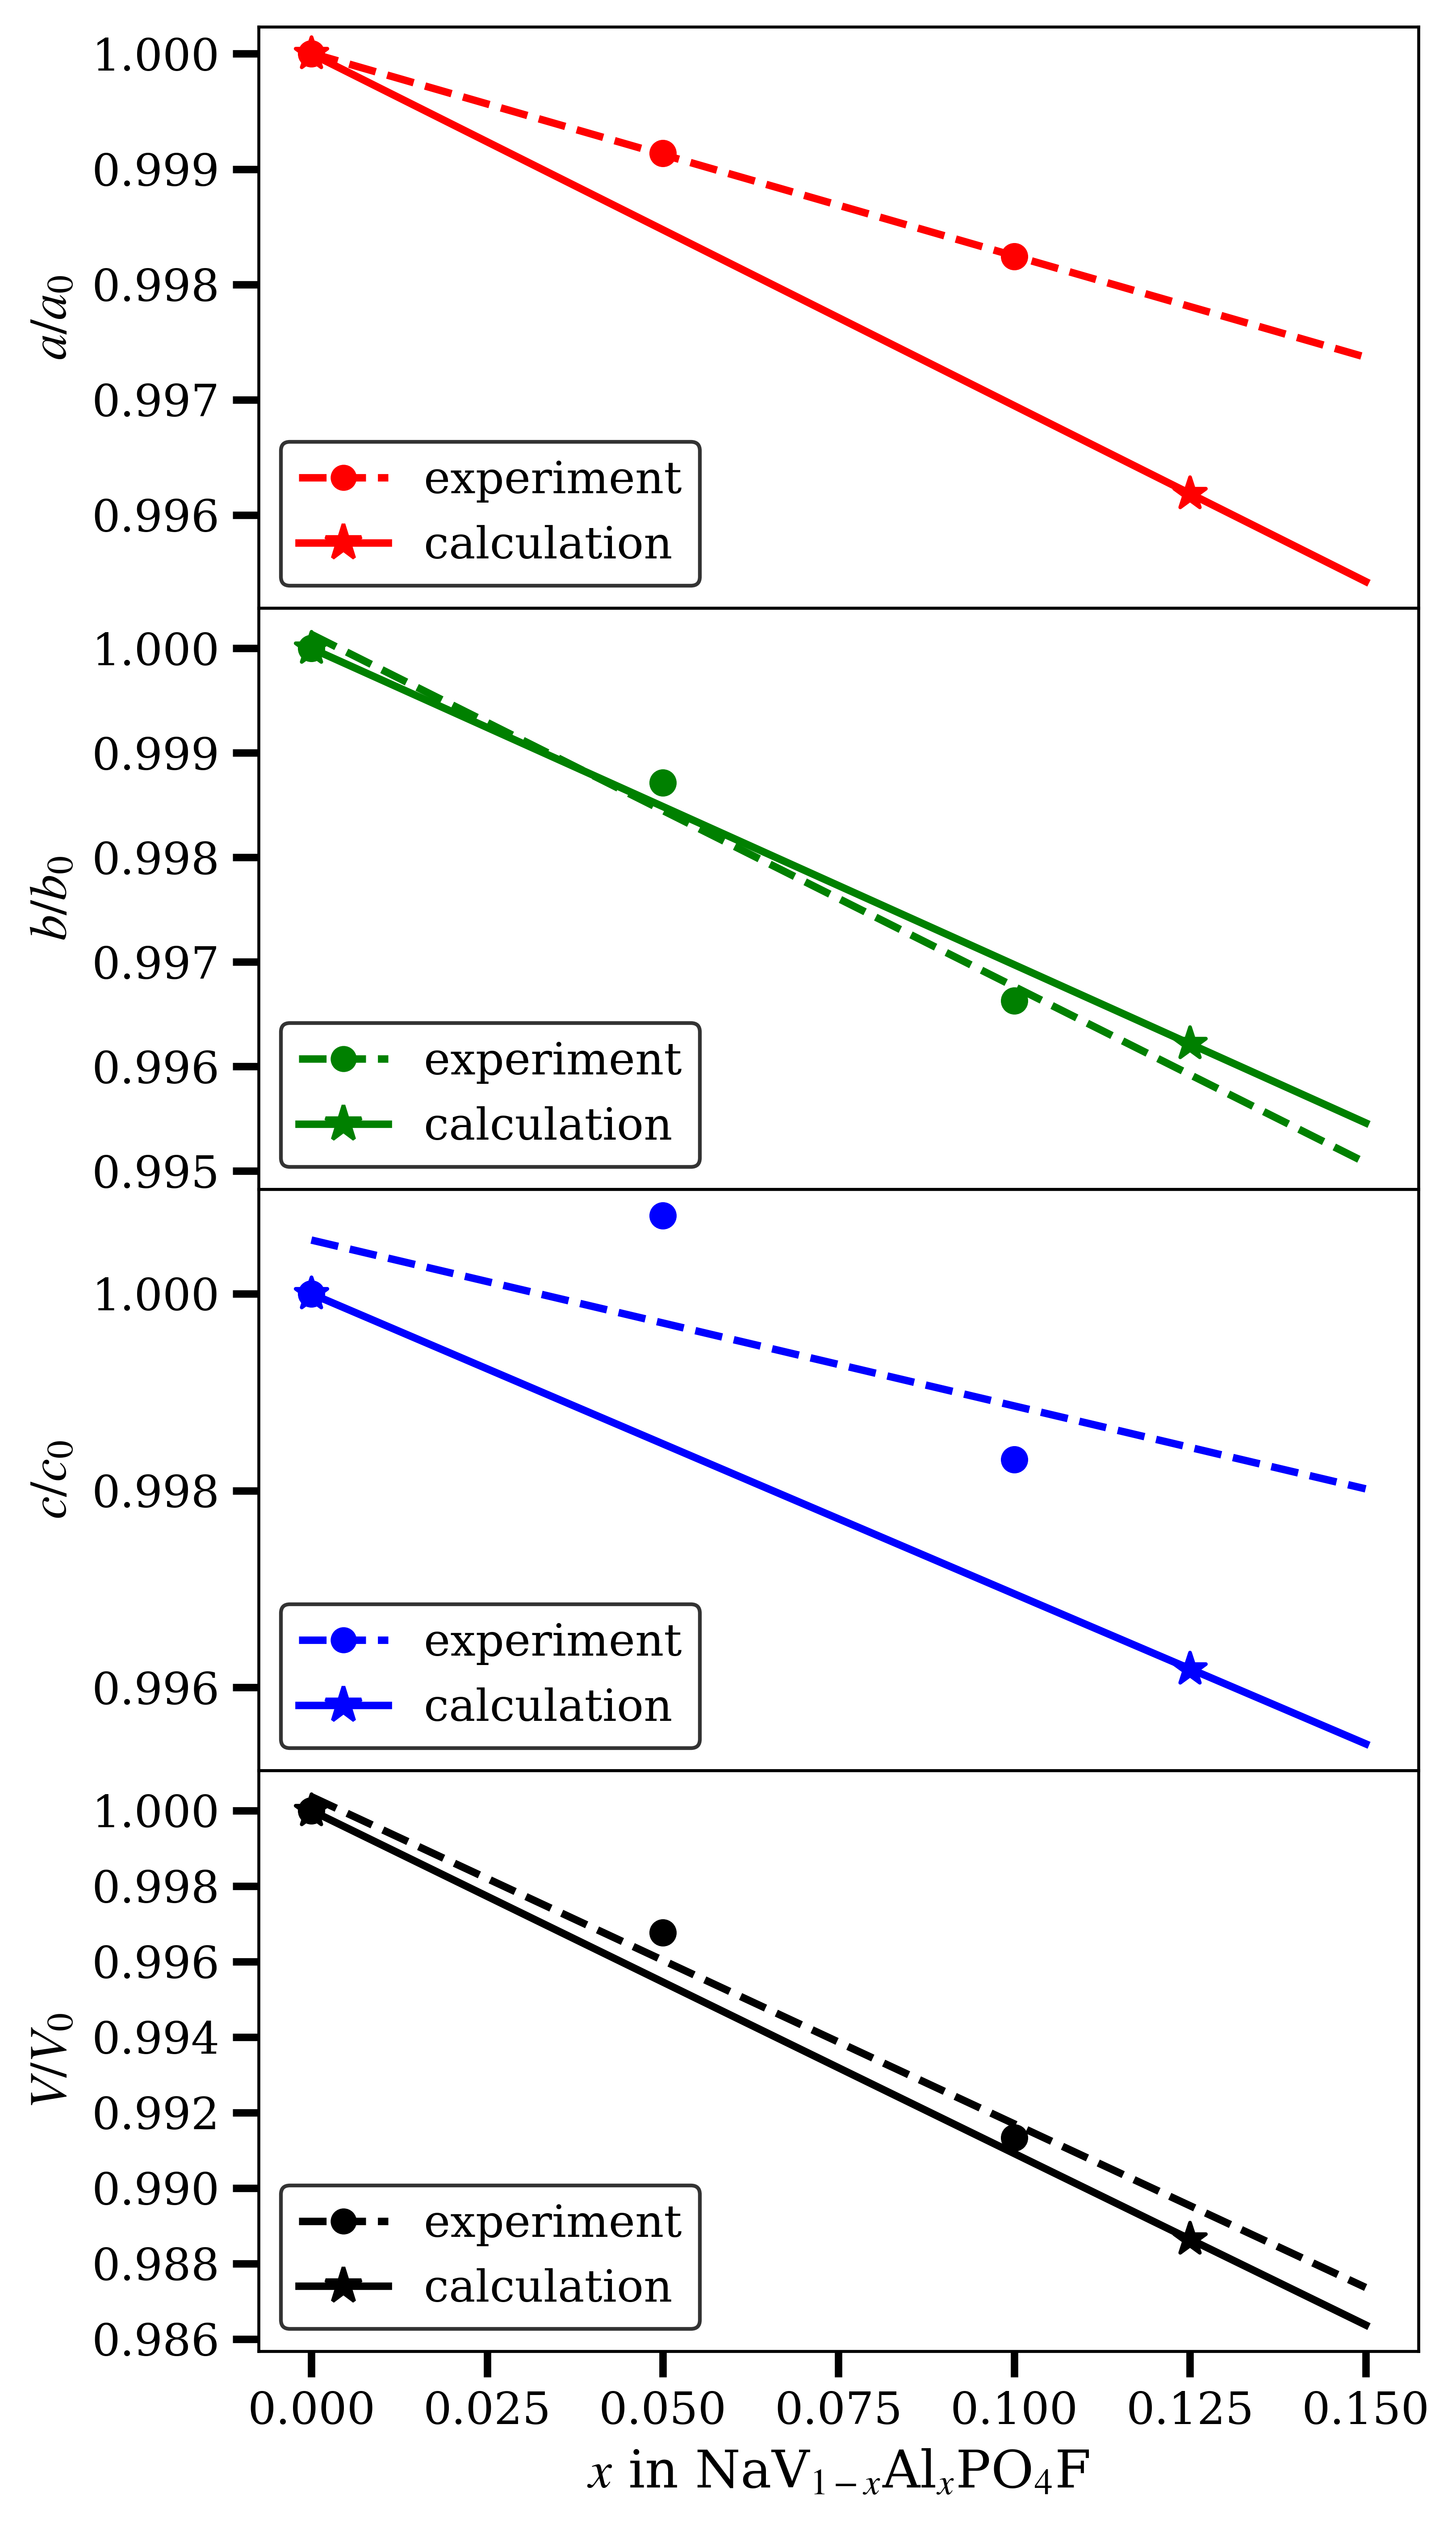

In [374]:
fontsize = 14
lw = 2.0
alpha = 0.35
x_fit = np.linspace(0, 0.15, 1000)

fig, ax = plt.subplots(4, 1, figsize=(6, 10), dpi=600)

for i in range(4):
    ax[i].locator_params(axis='x', nbins=8)
    if (i !=2):
        ax[i].locator_params(axis='y', nbins=8)
    else:
        ax[i].locator_params(axis='y', nbins=5)
        
    ax[i].set_ylabel(labels[i], fontsize=fontsize)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize-2)
    ax[i].tick_params(axis='both', which='minor', labelsize=fontsize-4)
    if (i != 3):
        ax[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[i].yaxis.get_offset_text().set_fontsize(10)
    ax[i].xaxis.set_tick_params(width=2, length=7)
    ax[i].yaxis.set_tick_params(width=2, length=7)
    
    coeffs = np.polyfit(ratios_exp, data_plot_exp[i], deg=1)  # degree 1 for linear
    y_fit = np.polyval(coeffs, x_fit)
    ax[i].plot(x_fit, y_fit, '--', color=colors[i], lw=lw, zorder=3)
    ax[i].scatter(ratios_exp, data_plot_exp[i], s=40, marker='o', color=colors[i], zorder=4)
    
    coeffs = np.polyfit(ratios_calc, data_plot_calc[i], deg=1)  # degree 1 for linear
    y_fit = np.polyval(coeffs, x_fit)
    ax[i].plot(x_fit, y_fit, '-', color=colors[i], lw=lw, zorder=3)
    ax[i].scatter(ratios_calc, data_plot_calc[i], s=80, marker='*', color=colors[i], )

    line_exp = Line2D([0], [0], linestyle='--', marker='o', color=colors[i], label="experiment", linewidth=2)
    line_calc = Line2D([0], [0], linestyle='-', marker='*', markersize=10, color=colors[i], label="calculation", linewidth=2)
    
    ax[i].legend(loc=3, fontsize=fontsize-2, edgecolor="black", handles=[line_exp, line_calc])


ax[3].set_xlabel(r'$x$ in NaV$_{1-x}$Al$_{x}$PO$_{4}$F', fontsize=fontsize)

plt.tight_layout()
plt.subplots_adjust(hspace=0.0)  # smaller values reduce horizontal padding

plt.show()

fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/ratios.png", dpi=600, bbox_inches='tight')
fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/ratios.pdf", dpi=600, bbox_inches='tight')



## Voronoi volume analysis

In [35]:
from ovito.modifiers import VoronoiAnalysisModifier
from ovito.io import import_file



In [36]:
def assign_particle_radii(frame, data):
    atom_types = data.particles_.particle_types_
    atom_types.type_by_id_(1).radius = 1.80  # Na
    atom_types.type_by_id_(2).radius = 1.35   # V 
    atom_types.type_by_id_(3).radius = 1.0  # P
    atom_types.type_by_id_(4).radius = 0.6  # O 
    atom_types.type_by_id_(5).radius = 0.5   # F
    

In [37]:
def assign_particle_radii_deinter(frame, data):
    atom_types = data.particles_.particle_types_
    atom_types.type_by_id_(1).radius = 1.35   # V 
    atom_types.type_by_id_(2).radius = 1.0  # P
    atom_types.type_by_id_(3).radius = 0.6  # O 
    atom_types.type_by_id_(4).radius = 0.5   # F
    

In [38]:
def assign_particle_radii_al(frame, data):
    atom_types = data.particles_.particle_types_
    atom_types.type_by_id_(1).radius = 1.80  # Na
    atom_types.type_by_id_(2).radius = 1.35   # V 
    atom_types.type_by_id_(3).radius = 1.0  # P
    atom_types.type_by_id_(4).radius = 0.6  # O 
    atom_types.type_by_id_(5).radius = 0.5   # F
    atom_types.type_by_id_(6).radius = 1.25   # Al
    

In [39]:
voro = VoronoiAnalysisModifier(
    compute_indices = False,
    use_radii = True,
    edge_threshold = 0.2
)


In [40]:
pipeline_inter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/inter.POSCAR")
pipeline_deinter = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/deinter.POSCAR")
pipeline_some_na = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/some_na.POSCAR")

pipeline_al = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_dist.POSCAR")
pipeline_al_some_na = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_some_na.POSCAR")
pipeline_al_some_na_dead = import_file("/home/arseniy/Desktop/work/nvpf_al_doped/data/structures/al_some_na_dead.POSCAR")


In [41]:
# file_inter = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/inter.XDATCAR"
# file_deinter = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/deinter.XDATCAR"
# file_some_na = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/some_na.XDATCAR"

# file_al = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al_dist.XDATCAR"
# file_al_some_na = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al_some_na.XDATCAR"
# file_al_some_na_dead = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al_some_na_dead.XDATCAR"




In [42]:
pipeline_inter.modifiers.append(assign_particle_radii)
pipeline_inter.modifiers.append(voro)

pipeline_some_na.modifiers.append(assign_particle_radii)
pipeline_some_na.modifiers.append(voro)

pipeline_deinter.modifiers.append(assign_particle_radii_deinter)
pipeline_deinter.modifiers.append(voro)

pipeline_al.modifiers.append(assign_particle_radii_al)
pipeline_al.modifiers.append(voro)

pipeline_al_some_na.modifiers.append(assign_particle_radii_al)
pipeline_al_some_na.modifiers.append(voro)

pipeline_al_some_na_dead.modifiers.append(assign_particle_radii_al)
pipeline_al_some_na_dead.modifiers.append(voro)



In [145]:
data_inter = []
data_deinter = []
data_some_na = []
data_al = []
data_al_some_na = []
data_al_some_na_dead = []

# Evaluate the data pipeline for the current frame
data_inter = pipeline_inter.compute(0)
data_deinter = pipeline_deinter.compute(0)
data_some_na = pipeline_some_na.compute(0)
data_al = pipeline_al.compute(0)
data_al_some_na = pipeline_al_some_na.compute(0)
data_al_some_na_dead = pipeline_al_some_na_dead.compute(0)

# Get per-atom properties
voronoi_volumes_inter = data_inter.particles['Atomic Volume']
types_inter = data_inter.particles['Particle Type']
voronoi_volumes_deinter = data_deinter.particles['Atomic Volume']
types_deinter = data_deinter.particles['Particle Type']
voronoi_volumes_al = data_al.particles['Atomic Volume']
types_al = data_al.particles['Particle Type']
voronoi_volumes_al_some_na = data_al_some_na.particles['Atomic Volume']
types_al_some_na = data_al_some_na.particles['Particle Type']
voronoi_volumes_some_na = data_some_na.particles['Atomic Volume']
types_some_na = data_some_na.particles['Particle Type']
voronoi_volumes_al_some_na_dead = data_al_some_na_dead.particles['Atomic Volume']
types_al_some_na_dead = data_al_some_na_dead.particles['Particle Type']

# Select only Li atoms (type 1)
vol_inter = voronoi_volumes_inter[types_inter == 2]
vol_deinter = voronoi_volumes_deinter[types_deinter == 1]
vol_al = voronoi_volumes_al[types_al == 2]
vol_al_some_na = voronoi_volumes_al_some_na[types_al_some_na == 2]
vol_some_na = voronoi_volumes_some_na[types_some_na == 2]
vol_al_some_na_dead = voronoi_volumes_al_some_na_dead[types_al_some_na_dead == 2]


# vol_inter = voronoi_volumes_inter[types_inter == 3]
# vol_deinter = voronoi_volumes_deinter[types_deinter == 2]
# vol_al = voronoi_volumes_al[types_al == 3]
# vol_al_some_na = voronoi_volumes_al_some_na[types_al_some_na == 3]
# vol_some_na = voronoi_volumes_some_na[types_some_na == 3]
# vol_al_some_na_dead = voronoi_volumes_al_some_na_dead[types_al_some_na_dead == 3]



In [144]:
data_p = [vol_inter, vol_some_na, vol_deinter, vol_al, vol_al_some_na_dead, vol_al_some_na]


In [64]:
vol_inter


array([11.49657305, 11.49643936, 11.49655487, 11.49674951, 11.11076891,
       11.11075203, 11.11077595, 11.1105943 , 11.49661618, 11.49640637,
       11.49640552, 11.49635518, 11.11039308, 11.11071689, 11.11072619,
       11.11044864])

In [146]:
data = [vol_inter, vol_some_na, vol_deinter, vol_al, vol_al_some_na_dead, vol_al_some_na]

In [147]:
labels = [
    r"NaVPO$_4$F",
    r"Na$_{0.1}$VPO$_4$F",
    r"VPO$_4$F",
    
    r"NaV$_{0.9}$Al$_{0.1}$PO$_4$F",
    r"Na$_{0.2}$V$_{0.9}$Al$_{0.1}$PO$_4$F",
    r"Na$_{0.1}$V$_{0.9}$Al$_{0.1}$PO$_4$F",
]


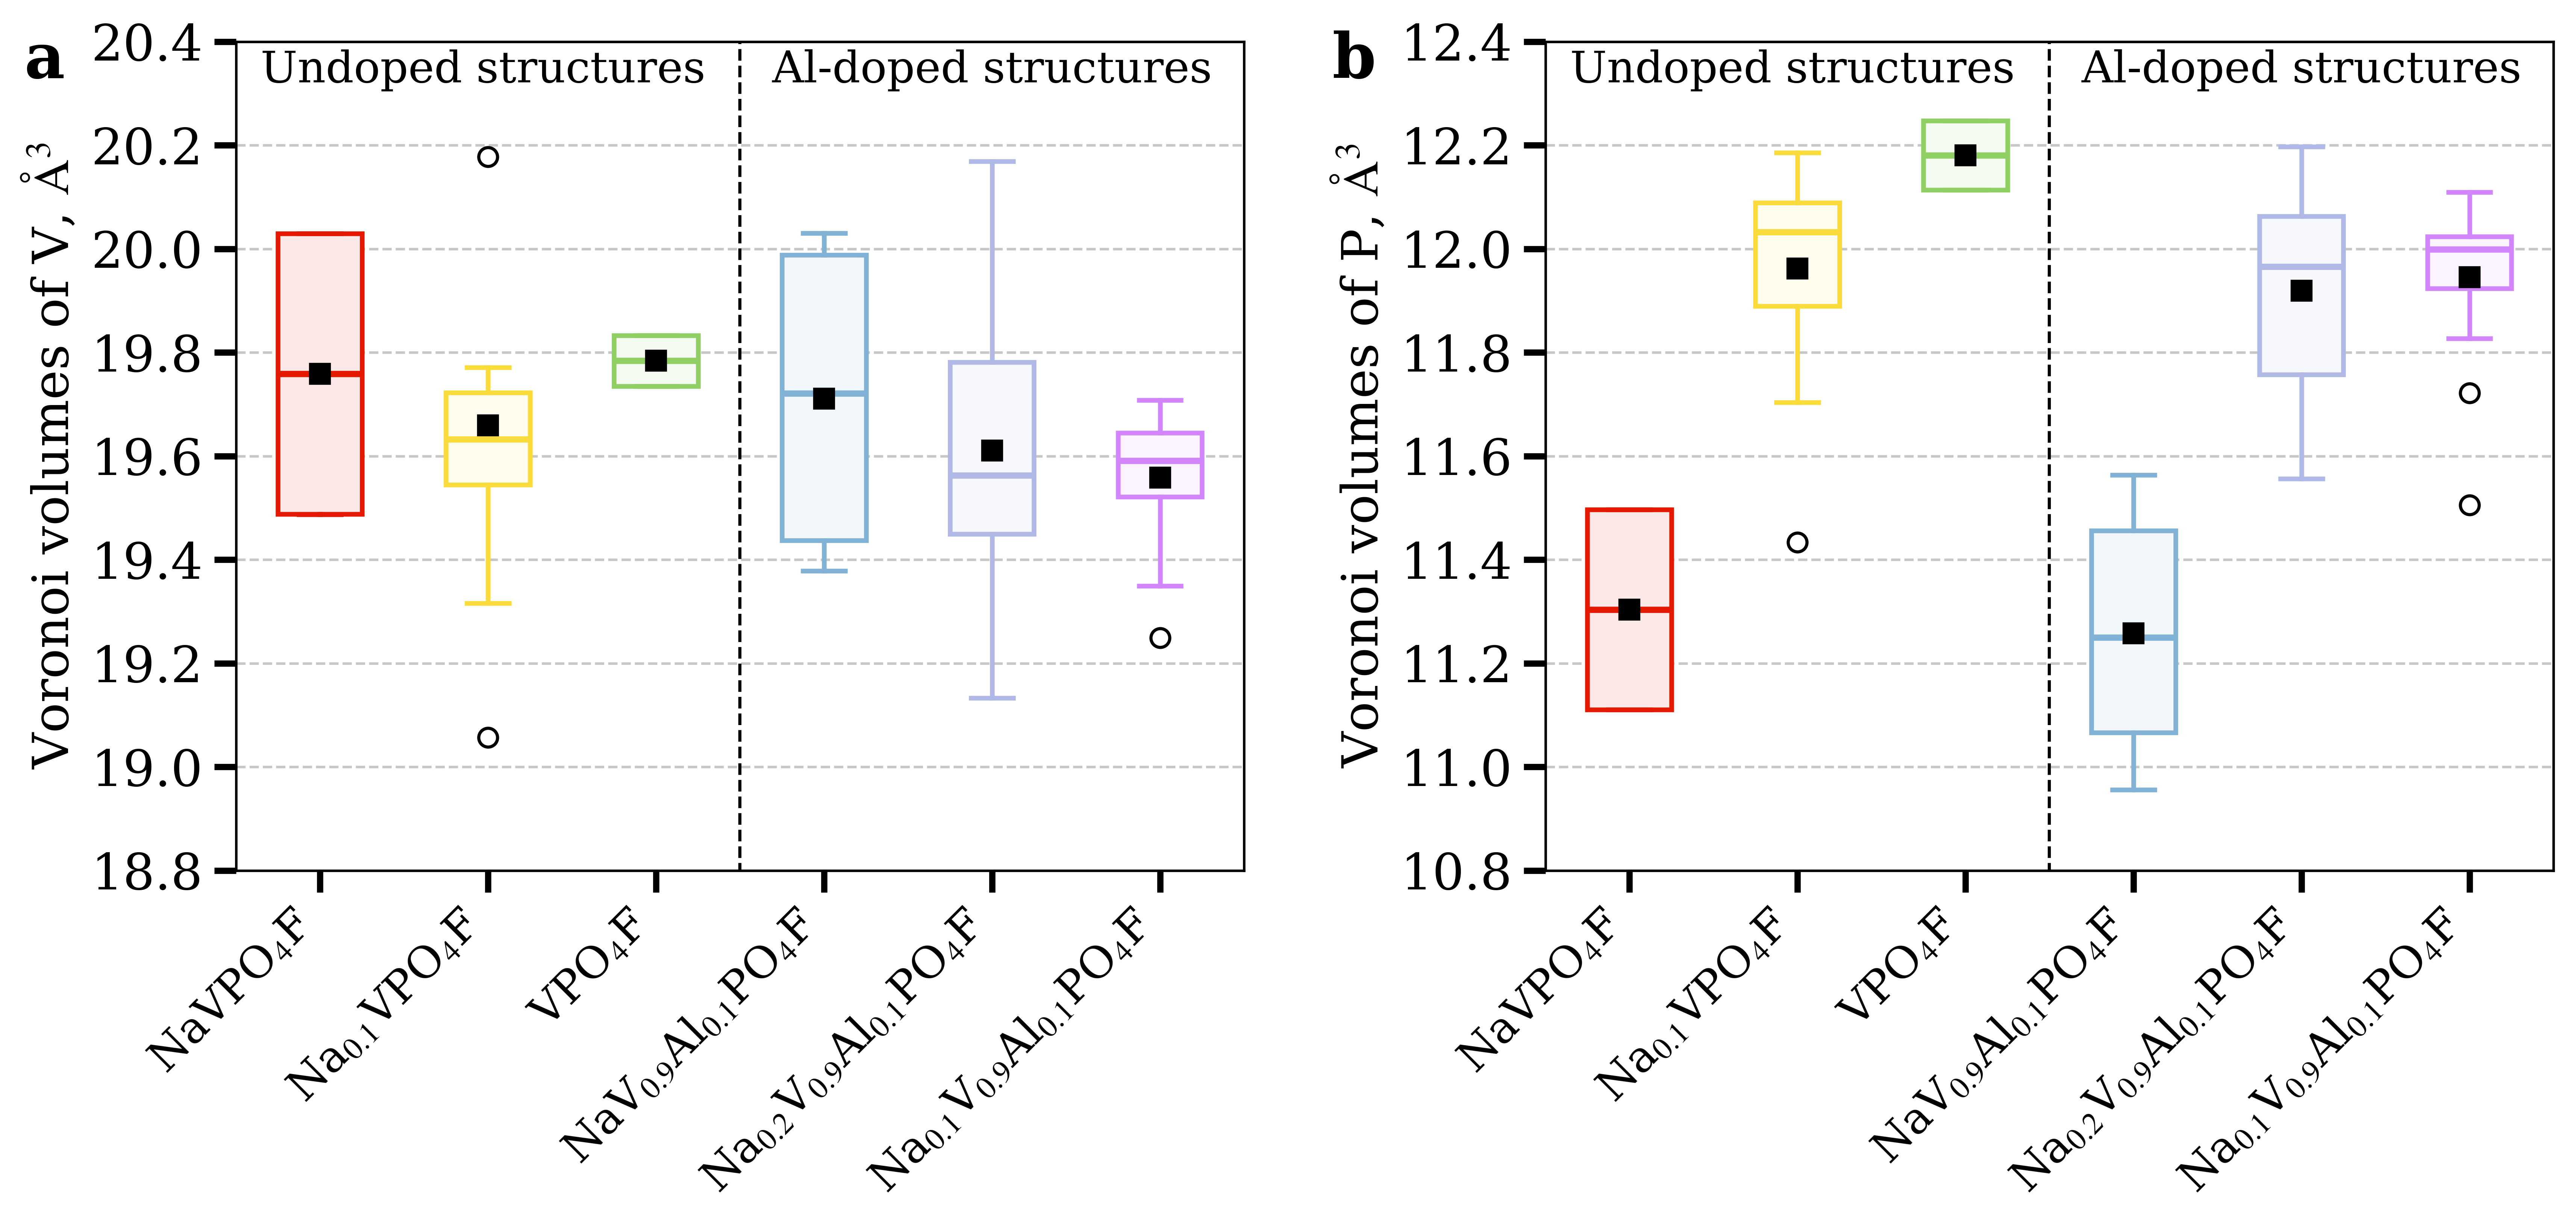

In [150]:
fontsize = 16
lw = 2.0
alpha = 0.1

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=600)
plt.tight_layout()

bp = ax.boxplot(data, patch_artist=True, showmeans=True, tick_labels=labels)

# Add titles and labels
ax.set_ylabel(r'Voronoi volumes of V, $\mathrm{\AA}^3$', fontsize=fontsize)
# ax.set_xlabel('Antisite defect type', fontsize=fontsize)

ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize-2)
ax.yaxis.get_offset_text().set_fontsize(10)
ax.xaxis.set_tick_params(width=2, length=7)
ax.yaxis.set_tick_params(width=2, length=7)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=fontsize-2)


# Show grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)


mean_color = 'black'
# fill_color = blend_with_white(colors_rgb["red"], alpha=0.1)

# box_colors = ['red', 'blue', 'green']
box_colors = [colors_rgb['V'], colors_rgb['Na'], colors_rgb['L'], colors_rgb['Al'], colors_rgb['F'], colors_rgb['R'], ]
mean_color = 'black'
fill_color = 'pink'

colors_for_whiskers = []
for c in box_colors:
    colors_for_whiskers.extend([c, c])  # repeat each color twice (for each whisker and cap)

for whisker, color in zip(bp['whiskers'], colors_for_whiskers):
    whisker.set(color=color, linewidth=1.5)

for cap, color in zip(bp['caps'], colors_for_whiskers):
    cap.set(color=color, linewidth=1.5)
    
# Set box fill and edge colors

for patch, color in zip(bp['boxes'], box_colors ):
    color_fill = [cc*255 for cc in color]
    fill_color = blend_with_white(color_fill, alpha=0.1)
    fill_color = tuple([color_fill/255 for color_fill in fill_color])
    patch.set(facecolor=fill_color, edgecolor=color, linewidth=1.5)

# Set medians color
for median, color in zip(bp['medians'], box_colors):
    median.set(color=color, linewidth=2)

# Set means color and style
for mean in bp['means']:
    mean.set(marker='s', markeredgecolor=mean_color, markerfacecolor=mean_color, markersize=6)
    

ax.vlines(3.5, 18.0, 21, linestyles='--', color="black", lw=1)
ax.set_ylim([18.8, 20.4], )
# ax.text([18.8, 20.4], )
ax.text(0.245, 0.94, "Undoped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)
ax.text(0.75, 0.94, "Al-doped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)



bp = ax2.boxplot(data_p, patch_artist=True, showmeans=True, tick_labels=labels)

# Add titles and labels
ax2.set_ylabel(r'Voronoi volumes of P, $\mathrm{\AA}^3$', fontsize=fontsize)
# ax2.set_xlabel('Antisite defect type', fontsize=fontsize)

ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize-2)
ax2.yaxis.get_offset_text().set_fontsize(10)
ax2.xaxis.set_tick_params(width=2, length=7)
ax2.yaxis.set_tick_params(width=2, length=7)
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=fontsize-2)


# Show grid for better readability
ax2.grid(axis='y', linestyle='--', alpha=0.7)


mean_color = 'black'
# fill_color = blend_with_white(colors_rgb["red"], alpha=0.1)

# box_colors = ['red', 'blue', 'green']
box_colors = [colors_rgb['V'], colors_rgb['Na'], colors_rgb['L'], colors_rgb['Al'], colors_rgb['F'], colors_rgb['R'], ]
mean_color = 'black'
fill_color = 'pink'

colors_for_whiskers = []
for c in box_colors:
    colors_for_whiskers.extend([c, c])  # repeat each color twice (for each whisker and cap)

for whisker, color in zip(bp['whiskers'], colors_for_whiskers):
    whisker.set(color=color, linewidth=1.5)

for cap, color in zip(bp['caps'], colors_for_whiskers):
    cap.set(color=color, linewidth=1.5)
    
# Set box fill and edge colors

for patch, color in zip(bp['boxes'], box_colors ):
    color_fill = [cc*255 for cc in color]
    fill_color = blend_with_white(color_fill, alpha=0.1)
    fill_color = tuple([color_fill/255 for color_fill in fill_color])
    patch.set(facecolor=fill_color, edgecolor=color, linewidth=1.5)

# Set medians color
for median, color in zip(bp['medians'], box_colors):
    median.set(color=color, linewidth=2)

# Set means color and style
for mean in bp['means']:
    mean.set(marker='s', markeredgecolor=mean_color, markerfacecolor=mean_color, markersize=6)
    

ax2.vlines(3.5, 0.0, 21, linestyles='--', color="black", lw=1)
ax2.set_ylim([10.8, 12.4], )
# ax2.text([18.8, 20.4], )
ax2.text(0.245, 0.94, "Undoped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax2.transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)
ax2.text(0.75, 0.94, "Al-doped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax2.transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)

ax2.text(-0.19, 0.94, "b",  horizontalalignment='center', verticalalignment='center', 
             transform=ax2.transAxes, ha='center', va='bottom', fontsize=fontsize+4, weight=1000)
ax.text(-0.19, 0.94, "a",  horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, ha='center', va='bottom', fontsize=fontsize+4, weight=1000)


plt.tight_layout()
plt.show()


fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/voronoi_volumes.png", dpi=600, bbox_inches='tight')
fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/voronoi_volumes.pdf", dpi=600, bbox_inches='tight')




In [47]:
for i in range(6):
    print(f"{np.mean(data[i]):.2f}", )

11.30
11.96
12.18
11.26
11.92
11.95


In [93]:
for i in range(6):
    print(f"{np.mean(data_p[i]):.2f}", )

11.30
11.96
12.18
11.26
11.92
11.95


## Volumes of V and P polyhedra

In [151]:
from ase.io import read
from scipy.spatial import ConvexHull
import numpy as np


In [152]:
def get_neighbors_indices_pbc(atoms, center_index, cutoff, elements=None):
    """Get neighbor indices within cutoff accounting for PBC."""
    distances = atoms.get_distances(center_index, range(len(atoms)), mic=True)
    neighbors = [
        i for i, d in enumerate(distances)
        if d < cutoff and i != center_index and (elements is None or atoms[i].symbol in elements)
    ]
    return neighbors

def wrap_coords_pbc(atoms, center_index, neighbor_indices):
    """Wrap neighbor coordinates applying PBC relative to center atom."""
    frac_pos = atoms.get_scaled_positions()
    center_frac = frac_pos[center_index]
    neigh_frac = frac_pos[neighbor_indices]

    disp = neigh_frac - center_frac
    disp -= np.round(disp)  # Wrap displacement to [-0.5, 0.5]
    wrapped_frac = center_frac + disp
    wrapped_cart = np.dot(wrapped_frac, atoms.get_cell())

    center_cart = atoms.get_positions()[center_index]
    coords = np.vstack([center_cart, wrapped_cart])
    return coords

def polyhedron_volume(coords):
    """Calculate volume of polyhedron defined by coords vertices."""
    hull = ConvexHull(coords)
    return hull.volume


def get_volumes_v(file_name):
    atoms_traj = read(file_name, index=':')    

    # Identify all V atoms (indices) in the first frame (assumed constant)
    v_indices = [i for i, atom in enumerate(atoms_traj[0]) if atom.symbol == 'V']
    vo4f2_volumes = []
    
    # Loop over all snapshots
    for atoms in atoms_traj:
        for v_i in v_indices:
            # VO4F2 polyhedron: at least 4 O and 2 F neighbors
            o_neighbors = get_neighbors_indices_pbc(atoms, v_i, cutoff=2.3, elements=['O'])
            f_neighbors = get_neighbors_indices_pbc(atoms, v_i, cutoff=2.5, elements=['F'])
            if len(o_neighbors) >= 4 and len(f_neighbors) >= 2:
                neighbors_selected = o_neighbors[:4] + f_neighbors[:2]
                coords = wrap_coords_pbc(atoms, v_i, neighbors_selected)
                vol = polyhedron_volume(coords)
                vo4f2_volumes.append(vol)
    
    # Report average volumes
    vo4f2_volumes = [vol for vol in vo4f2_volumes if vol < 14.0]
    
    return vo4f2_volumes

def get_volumes_p(file_name):
    atoms_traj = read(file_name, index=':')    

    # Identify all V atoms (indices) in the first frame (assumed constant)
    p_indices = [i for i, atom in enumerate(atoms_traj[0]) if atom.symbol == 'P']
    
    po4_volumes = []
    
    # Loop over all snapshots
    for atoms in atoms_traj[10:]:
        for p_i in p_indices:
            o_neighbors = get_neighbors_indices_pbc(atoms, p_i, cutoff=2.5, elements=['O'])
            if len(o_neighbors) >= 4:
                neighbors_selected = o_neighbors[:4]
                coords = wrap_coords_pbc(atoms, p_i, neighbors_selected)
                vol = polyhedron_volume(coords)
                po4_volumes.append(vol)
    
    # Report average volumes
    po4_volumes = [vol for vol in po4_volumes if vol < 3.0]
    
    return po4_volumes


In [153]:
file_inter = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/inter.XDATCAR"
file_deinter = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/deinter.XDATCAR"
file_some_na = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/some_na.XDATCAR"

file_al = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al_dist.XDATCAR"
file_al_some_na = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al_some_na.XDATCAR"
file_al_some_na_dead = "/home/arseniy/Desktop/work/nvpf_al_doped/data/aimd/al_some_na_dead.XDATCAR"



In [154]:
v_vols_inter = get_volumes_v(file_inter)
p_vols_inter = get_volumes_p(file_inter)

v_vols_deinter = get_volumes_v(file_deinter)
p_vols_deinter = get_volumes_p(file_deinter)

v_vols_some_na = get_volumes_v(file_some_na)
p_vols_some_na = get_volumes_p(file_some_na)

v_vols_al = get_volumes_v(file_al)
p_vols_al = get_volumes_p(file_al)

v_vols_al_some_na = get_volumes_v(file_al_some_na)
p_vols_al_some_na = get_volumes_p(file_al_some_na)

v_vols_al_some_na_dead = get_volumes_v(file_al_some_na_dead)
p_vols_al_some_na_dead = get_volumes_p(file_al_some_na_dead)


In [155]:
data_v = [v_vols_inter, v_vols_deinter, v_vols_some_na, v_vols_al, v_vols_al_some_na, v_vols_al_some_na_dead]

In [156]:
data_p = [p_vols_inter, p_vols_deinter, p_vols_some_na, p_vols_al, p_vols_al_some_na, p_vols_al_some_na_dead]

In [164]:
for i in range(6):
    print(round(np.mean(data_p[i]),2))

1.94
1.92
1.88
1.93
1.91
1.91


In [161]:
np.mean(data_v[0])

10.788693132958493

In [118]:
labels = [
    r"NaVPO$_4$F",
    r"Na$_{0.1}$VPO$_4$F",
    r"VPO$_4$F",
    
    r"NaV$_{0.9}$Al$_{0.1}$PO$_4$F",
    r"Na$_{0.2}$V$_{0.9}$Al$_{0.1}$PO$_4$F",
    r"Na$_{0.1}$V$_{0.9}$Al$_{0.1}$PO$_4$F",
]


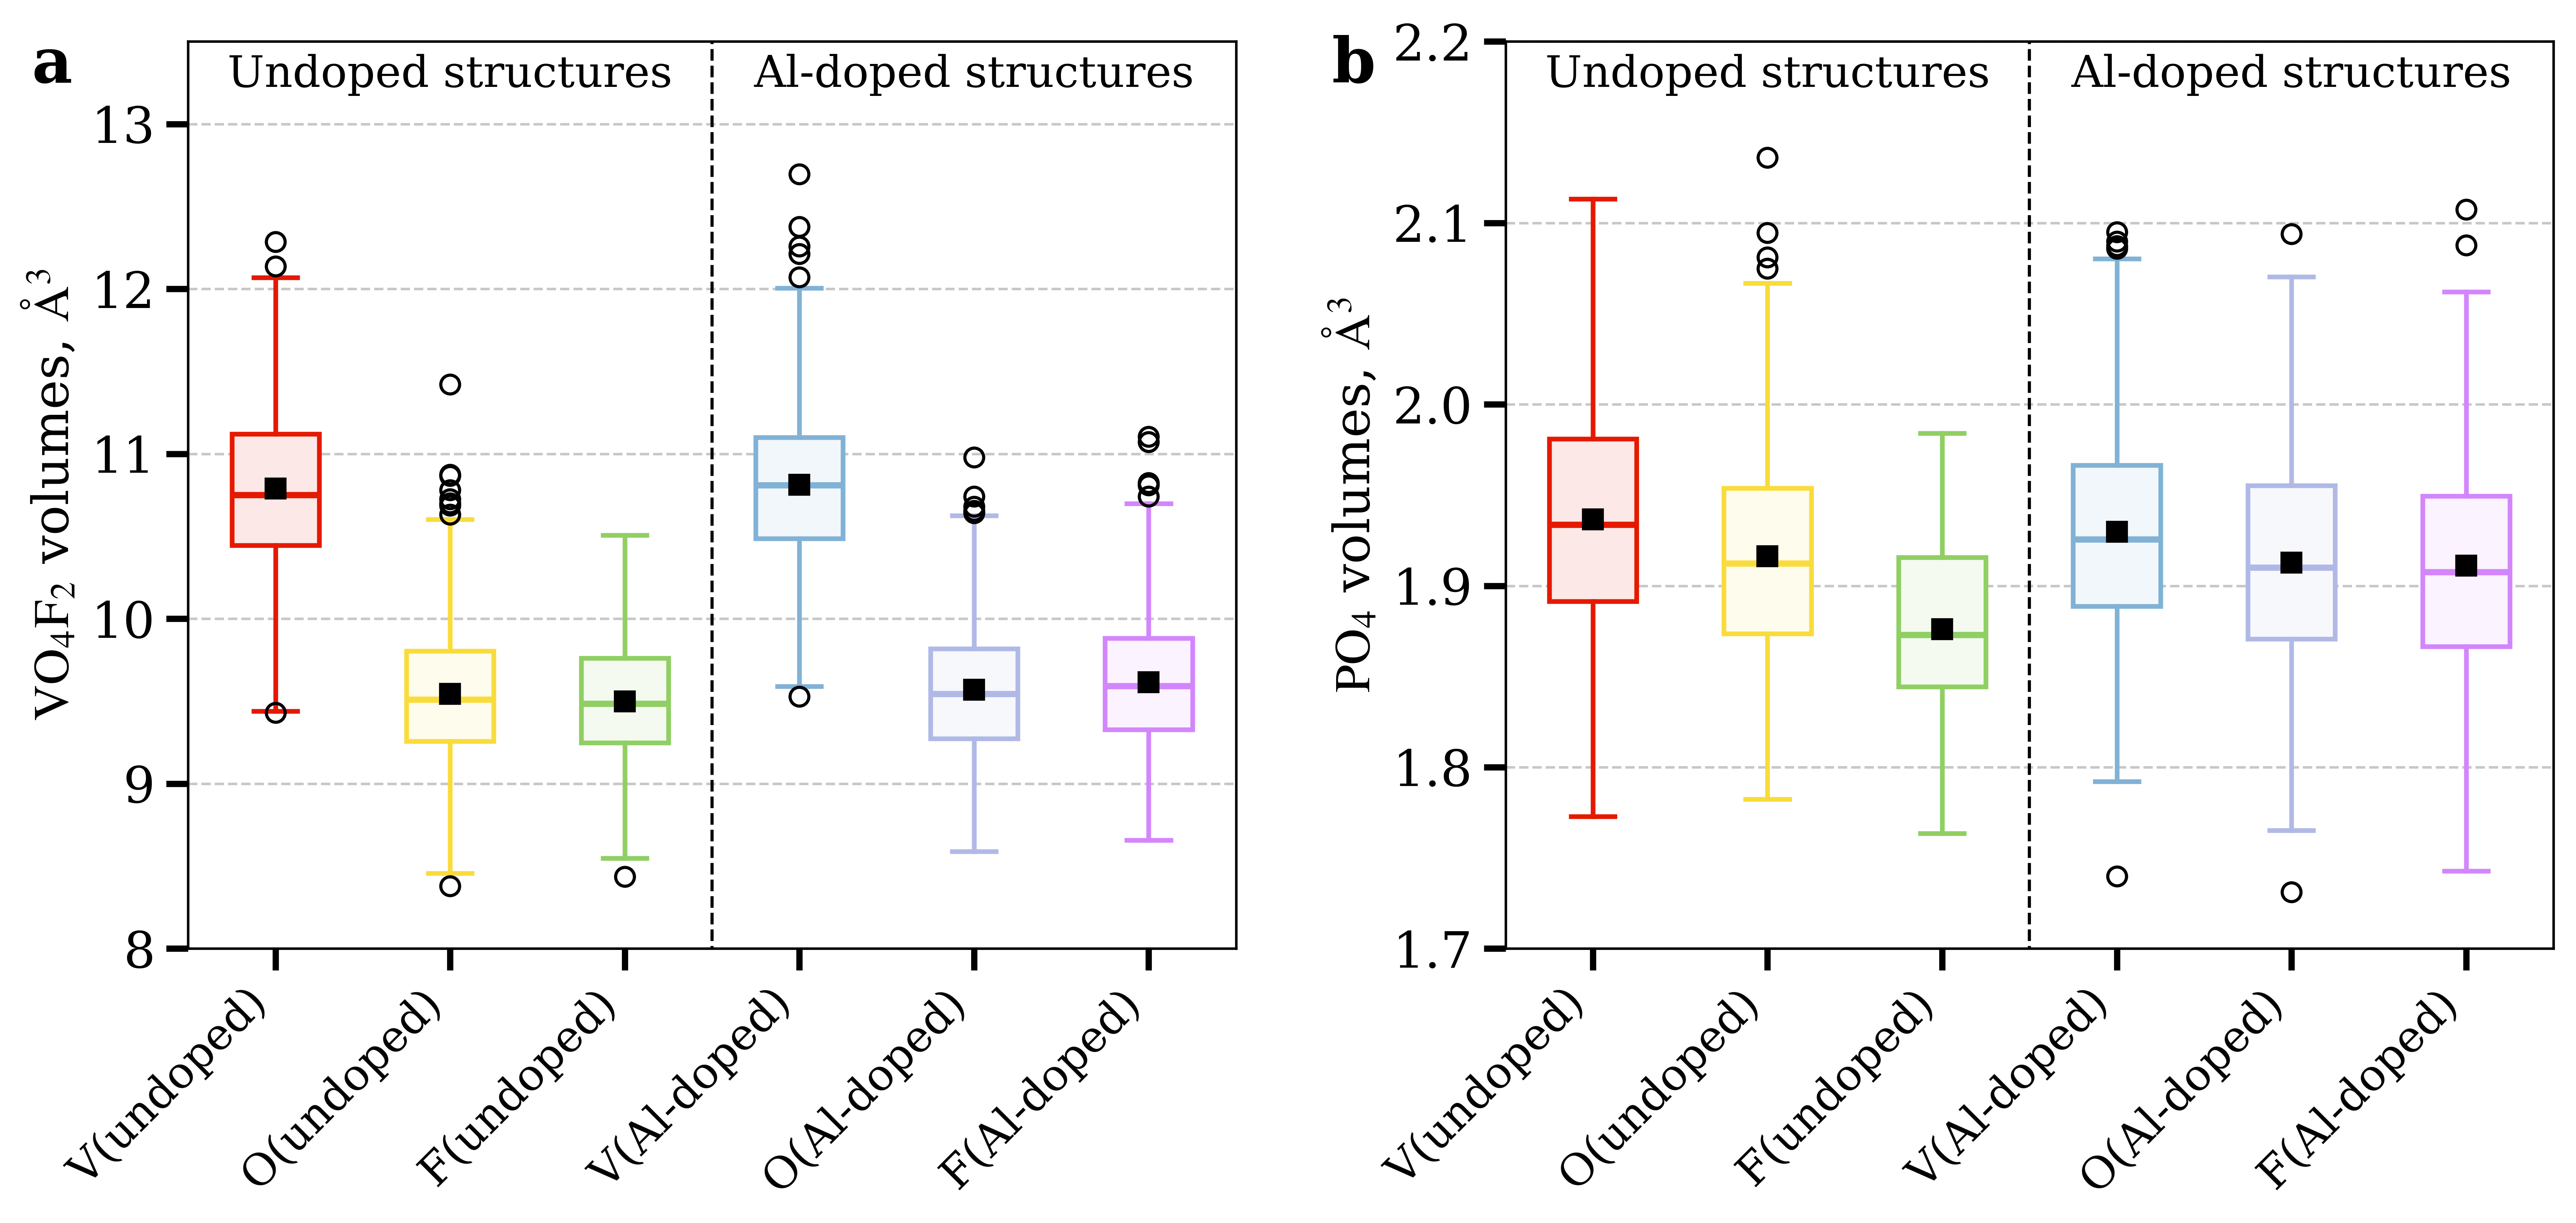

In [141]:
fontsize = 16
lw = 2.0
alpha = 0.1

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=600)
plt.tight_layout()

bp = ax.boxplot(data_v, patch_artist=True, showmeans=True, tick_labels=labels)

# Add titles and labels
ax.set_ylabel(r'$\mathrm{VO}_{4}\mathrm{F}_2$ volumes, $\mathrm{\AA}^3$', fontsize=fontsize)
# ax.set_xlabel('Antisite defect type', fontsize=fontsize)

ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize-2)
ax.yaxis.get_offset_text().set_fontsize(10)
ax.xaxis.set_tick_params(width=2, length=7)
ax.yaxis.set_tick_params(width=2, length=7)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=fontsize-2)


# Show grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)


mean_color = 'black'
# fill_color = blend_with_white(colors_rgb["red"], alpha=0.1)

# box_colors = ['red', 'blue', 'green']
box_colors = [colors_rgb['V'], colors_rgb['Na'], colors_rgb['L'], colors_rgb['Al'], colors_rgb['F'], colors_rgb['R'], ]
mean_color = 'black'
fill_color = 'pink'

colors_for_whiskers = []
for c in box_colors:
    colors_for_whiskers.extend([c, c])  # repeat each color twice (for each whisker and cap)

for whisker, color in zip(bp['whiskers'], colors_for_whiskers):
    whisker.set(color=color, linewidth=1.5)

for cap, color in zip(bp['caps'], colors_for_whiskers):
    cap.set(color=color, linewidth=1.5)
    
# Set box fill and edge colors

for patch, color in zip(bp['boxes'], box_colors ):
    color_fill = [cc*255 for cc in color]
    fill_color = blend_with_white(color_fill, alpha=0.1)
    fill_color = tuple([color_fill/255 for color_fill in fill_color])
    patch.set(facecolor=fill_color, edgecolor=color, linewidth=1.5)

# Set medians color
for median, color in zip(bp['medians'], box_colors):
    median.set(color=color, linewidth=2)

# Set means color and style
for mean in bp['means']:
    mean.set(marker='s', markeredgecolor=mean_color, markerfacecolor=mean_color, markersize=6)
    

ax.vlines(3.5, 0.0, 21, linestyles='--', color="black", lw=1)
ax.set_ylim([8.0, 13.5], )
# ax.text([18.8, 20.4], )
ax.text(0.25, 0.94, "Undoped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)
ax.text(0.75, 0.94, "Al-doped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)


bp = ax2.boxplot(data_p, patch_artist=True, showmeans=True, tick_labels=labels)

# Add titles and labels
ax2.set_ylabel(r'$\mathrm{PO}_{4}$ volumes, $\mathrm{\AA}^3$', fontsize=fontsize)
# ax2.set_xlabel('Antisite defect type', fontsize=fontsize)

ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize-2)
ax2.yaxis.get_offset_text().set_fontsize(10)
ax2.xaxis.set_tick_params(width=2, length=7)
ax2.yaxis.set_tick_params(width=2, length=7)
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=fontsize-2)


# Show grid for better readability
ax2.grid(axis='y', linestyle='--', alpha=0.7)


mean_color = 'black'
# fill_color = blend_with_white(colors_rgb["red"], alpha=0.1)

# box_colors = ['red', 'blue', 'green']
box_colors = [colors_rgb['V'], colors_rgb['Na'], colors_rgb['L'], colors_rgb['Al'], colors_rgb['F'], colors_rgb['R'], ]
mean_color = 'black'
fill_color = 'pink'

colors_for_whiskers = []
for c in box_colors:
    colors_for_whiskers.extend([c, c])  # repeat each color twice (for each whisker and cap)

for whisker, color in zip(bp['whiskers'], colors_for_whiskers):
    whisker.set(color=color, linewidth=1.5)

for cap, color in zip(bp['caps'], colors_for_whiskers):
    cap.set(color=color, linewidth=1.5)
    
# Set box fill and edge colors

for patch, color in zip(bp['boxes'], box_colors ):
    color_fill = [cc*255 for cc in color]
    fill_color = blend_with_white(color_fill, alpha=0.1)
    fill_color = tuple([color_fill/255 for color_fill in fill_color])
    patch.set(facecolor=fill_color, edgecolor=color, linewidth=1.5)

# Set medians color
for median, color in zip(bp['medians'], box_colors):
    median.set(color=color, linewidth=2)

# Set means color and style
for mean in bp['means']:
    mean.set(marker='s', markeredgecolor=mean_color, markerfacecolor=mean_color, markersize=6)
    

ax2.vlines(3.5, 0.0, 21, linestyles='--', color="black", lw=1)
# ax2.text([18.8, 20.4], )
ax2.text(0.25, 0.94, "Undoped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax2.transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)
ax2.text(0.75, 0.94, "Al-doped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax2.transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)

ax2.text(-0.145, 0.94, "b",  horizontalalignment='center', verticalalignment='center', 
             transform=ax2.transAxes, ha='center', va='bottom', fontsize=fontsize+4, weight=1000)
ax.text(-0.13, 0.94, "a",  horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, ha='center', va='bottom', fontsize=fontsize+4, weight=1000)

ax2.set_ylim([1.7, 2.2], )

plt.tight_layout()
plt.show()


fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/atomic_volumes.png", dpi=600, bbox_inches='tight')
fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/atomic_volumes.pdf", dpi=600, bbox_inches='tight')




## Combined DOS plots

In [62]:
from scipy.ndimage import gaussian_filter1d


In [63]:
def load_data(file_path):
    data = np.loadtxt(file_path)
    energy = data[:, 0]
    # total_electrons = np.abs(data[:, 1]) + np.abs(data[:, 2])  # up + down electrons
    total_electrons = data[:, 1] + data[:, 2]  # up + down electrons
    
    return energy, total_electrons


In [64]:
data_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/dos/combined/inter/"

data_path_some_na = "/home/arseniy/Desktop/work/nvpf_al_doped/data/dos/combined/some_na/" 

data_path_deinter = "/home/arseniy/Desktop/work/nvpf_al_doped/data/dos/combined/deinter/" 


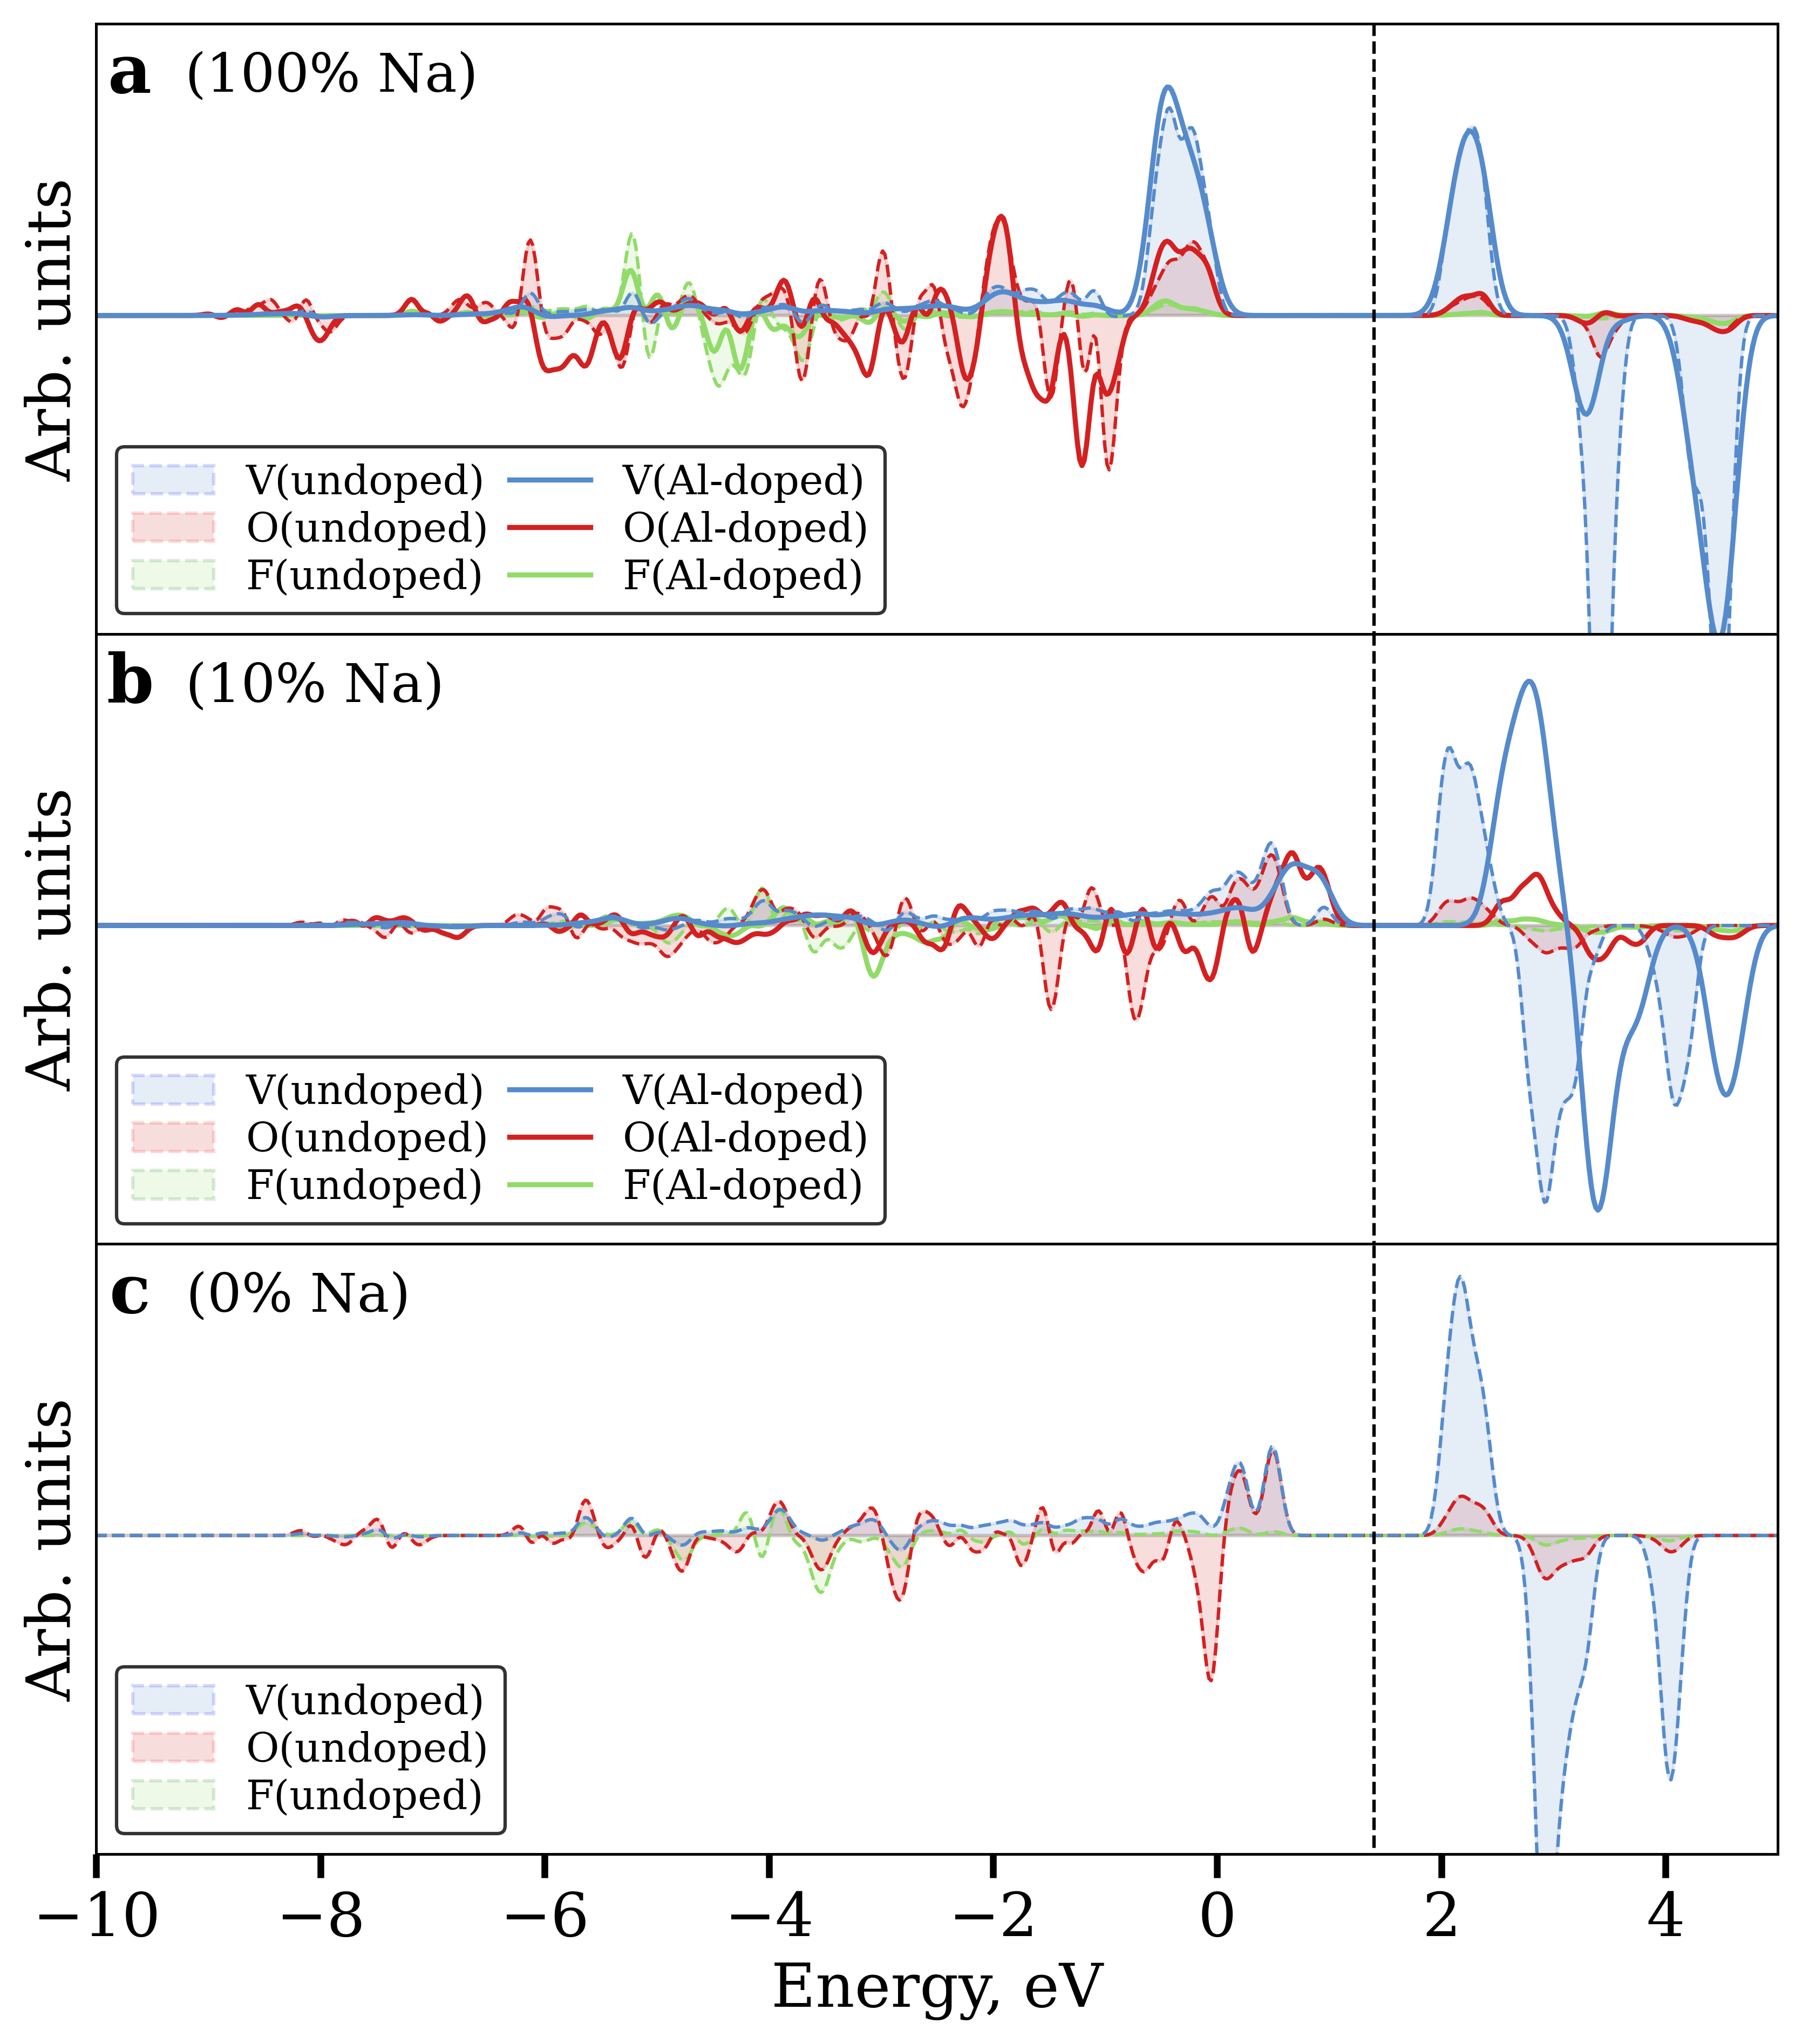

In [76]:

# List of data files in the directory
files = [
    "F_dos_al.dat",
    "F_dos.dat",
    "O_dos_al.dat",
    "O_dos.dat",
    "V_dos_al.dat",
    "V_dos.dat"
]

files_deinter = [
    "F_dos.dat",
    "O_dos.dat",
    "V_dos.dat"
]

labels = [
    "V(undoped)",
    "O(undoped)",
    "F(undoped)",
    "V(Al-doped)",
    "O(Al-doped)",
    "F(Al-doped)",
]



# Organize data by species and calculation type
species_data = {}
species_data_deinter = {}
species_data_some_na = {}

for file in files:
    species, calc_type_ext = file.split("_", 1)
    calc_type = calc_type_ext.split(".")[0]  # remove extension
    if species not in species_data:
        species_data[species] = {}
    file_path = os.path.join(data_path, file)
    energy, total_electrons = load_data(file_path)
    species_data[species][calc_type] = (energy, total_electrons)

for file in files:
    species, calc_type_ext = file.split("_", 1)
    calc_type = calc_type_ext.split(".")[0]  # remove extension
    if species not in species_data_some_na:
        species_data_some_na[species] = {}
    file_path = os.path.join(data_path_some_na, file)
    energy, total_electrons = load_data(file_path)
    species_data_some_na[species][calc_type] = (energy+1.0, total_electrons)

for file in files_deinter:
    species, calc_type_ext = file.split("_", 1)
    calc_type = calc_type_ext.split(".")[0]  # remove extension
    if species not in species_data_deinter:
        species_data_deinter[species] = {}
    file_path = os.path.join(data_path_deinter, file)
    energy, total_electrons = load_data(file_path)
    species_data_deinter[species][calc_type] = (energy+0.6, total_electrons)


v_patch = mpatches.Rectangle((0, 0), 1, 1,  facecolor=colors_rgb["V_dos"], edgecolor="b", alpha=alpha,
                                linestyle='--',  linewidth=1, label=labels[0])
o_patch = mpatches.Rectangle((0, 0), 1, 1,  facecolor=colors_rgb["O_dos"], edgecolor="r", alpha=alpha,
                                linestyle='--',  linewidth=1, label=labels[0])
f_patch = mpatches.Rectangle((0, 0), 1, 1,  facecolor=colors_rgb["F_dos"], edgecolor="g", alpha=alpha,
                                linestyle='--',  linewidth=1, label=labels[0])
v_line = Line2D([0], [0], linestyle='-', color=colors_rgb["V_dos"], label=labels[1], linewidth=1.5)
o_line = Line2D([0], [0], linestyle='-', color=colors_rgb["O_dos"], label=labels[1], linewidth=1.5)
f_line = Line2D([0], [0], linestyle='-', color=colors_rgb["F_dos"], label=labels[1], linewidth=1.5)

patches = [v_patch, o_patch, f_patch, v_line, o_line, f_line]


# Plot the total electrons vs energy
fig, ax = plt.subplots(3, 1, figsize=(8, 9), sharex=True, )

fontsize = 18
sigma = 2  # Adjust sigma for smearing strength
alpha = 0.15

for i, (species, calculations) in enumerate(species_data.items()):
    for calc_type, (energy, total_electrons) in calculations.items():
        total_electrons_smooth = gaussian_filter1d(total_electrons, sigma=sigma)
        if "O" in species:
            color = colors_rgb["O_dos"]
        elif "V" in species:
            color = colors_rgb["V_dos"]
        elif "Al" in species:
            color = colors_rgb["Al_dos"]
        elif "F" in species:
            color = colors_rgb["F_dos"]
        
        if "al" in calc_type:
            ax[0].plot(energy, total_electrons_smooth, label=f"{calc_type}_{species}", lw=1.5, color=color)
        else:
            ax[0].plot(energy, total_electrons_smooth, '--', label=f"{calc_type}_{species}", lw=1, color=color)
            ax[0].fill_between(energy, total_electrons_smooth, 0, alpha=alpha, color=color)

for i, (species, calculations) in enumerate(species_data_some_na.items()):
    for calc_type, (energy, total_electrons) in calculations.items():
        total_electrons_smooth = gaussian_filter1d(total_electrons, sigma=sigma)
        if "O" in species:
            color = colors_rgb["O_dos"]
        elif "V" in species:
            color = colors_rgb["V_dos"]
        elif "Al" in species:
            color = colors_rgb["Al_dos"]
        elif "F" in species:
            color = colors_rgb["F_dos"]
        
        if "al" in calc_type:
            ax[1].plot(energy, total_electrons_smooth, label=f"{calc_type}_{species}", lw=1.5, color=color)
        else:
            ax[1].plot(energy, total_electrons_smooth, '--', label=f"{calc_type}_{species}", lw=1, color=color)
            ax[1].fill_between(energy, total_electrons_smooth, 0, alpha=alpha, color=color)

for i, (species, calculations) in enumerate(species_data_deinter.items()):
    for calc_type, (energy, total_electrons) in calculations.items():
        total_electrons_smooth = gaussian_filter1d(total_electrons, sigma=sigma)
        if "O" in species:
            color = colors_rgb["O_dos"]
        elif "V" in species:
            color = colors_rgb["V_dos"]
        elif "Al" in species:
            color = colors_rgb["Al_dos"]
        elif "F" in species:
            color = colors_rgb["F_dos"]
        
        if "al" in calc_type:
            ax[2].plot(energy, total_electrons_smooth, label=f"{calc_type}_{species}", lw=1.5, color=color)
        else:
            ax[2].plot(energy, total_electrons_smooth, '--', label=f"{calc_type}_{species}", lw=1, color=color)
            ax[2].fill_between(energy, total_electrons_smooth, 0, alpha=alpha, color=color)


for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i].tick_params(axis='both', which='minor', labelsize=fontsize-2)
    ax[i].yaxis.get_offset_text().set_fontsize(10)
    ax[i].xaxis.set_tick_params(width=2, length=7)
    ax[i].yaxis.set_tick_params(width=2, length=7)
    ax[i].set_ylabel("Arb. units", fontsize=fontsize)
    ax[i].set_xlabel("Energy, eV", fontsize=fontsize)
    ax[i].set_yticks([])

    ax[i].vlines(1.4, -200, 200, linestyle='--', color="black", lw=1)
    ax[i].set_xlim([-10, 5])
    ax[i].set_ylim([-60, 55])
    # ax.set_ylim([-20, 20])

    if i < 2:
        ax[i].legend(edgecolor="black", loc=3, ncol=2, handles=patches, labels=labels, 
                     columnspacing=0.5, labelspacing=0.2, fontsize=fontsize-6)
    else:
        ax[i].legend(edgecolor="black", loc=3, ncol=1, handles=patches[0:3], labels=labels[0:3], 
                     columnspacing=0.5, labelspacing=0.2, fontsize=fontsize-6)
        
ax[0].set_xlabel("")
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax[1].set_xlabel("")
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax[0].text(0.02, 0.865, r"a",  horizontalalignment='center', verticalalignment='center', 
             transform=ax[0].transAxes, ha='center', va='bottom', fontsize=fontsize+2, weight=1000)
ax[0].text(0.14, 0.87, r"(100% Na)",  horizontalalignment='center', verticalalignment='center', 
             transform=ax[0].transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)
ax[1].text(0.02, 0.865, r"b",  horizontalalignment='center', verticalalignment='center', 
             transform=ax[1].transAxes, ha='center', va='bottom', fontsize=fontsize+2, weight=1000)
ax[1].text(0.13, 0.87, r"(10% Na)",  horizontalalignment='center', verticalalignment='center', 
             transform=ax[1].transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)
ax[2].text(0.02, 0.865, r"c",  horizontalalignment='center', verticalalignment='center', 
             transform=ax[2].transAxes, ha='center', va='bottom', fontsize=fontsize+2, weight=1000)
ax[2].text(0.12, 0.87, r"(0% Na)",  horizontalalignment='center', verticalalignment='center', 
             transform=ax[2].transAxes, ha='center', va='bottom', fontsize=fontsize-2, weight=400)


plt.tight_layout()
plt.subplots_adjust(hspace=0.0)  # smaller values reduce horizontal padding
plt.show()


fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/dos_total.png", dpi=600, bbox_inches='tight')
fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/dos_total.pdf", dpi=600, bbox_inches='tight')




# Thermodynamic stability

In [428]:
data = [-5, -4, -6, -0.07, 5, 3]

data_x = [1, 2, 3, 4, 5, 6]

In [429]:
labels = [
    'a',
    r"NaVPO$_4$F",
    r"Na$_{0.1}$VPO$_4$F",
    r"VPO$_4$F",
    
    r"NaV$_{0.9}$Al$_{0.1}$PO$_4$F",
    r"Na$_{0.2}$V$_{0.9}$Al$_{0.1}$PO$_4$F",
    r"Na$_{0.1}$V$_{0.9}$Al$_{0.1}$PO$_4$F",
]


/tmp/ipykernel_69623/3486112066.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=fontsize-2)


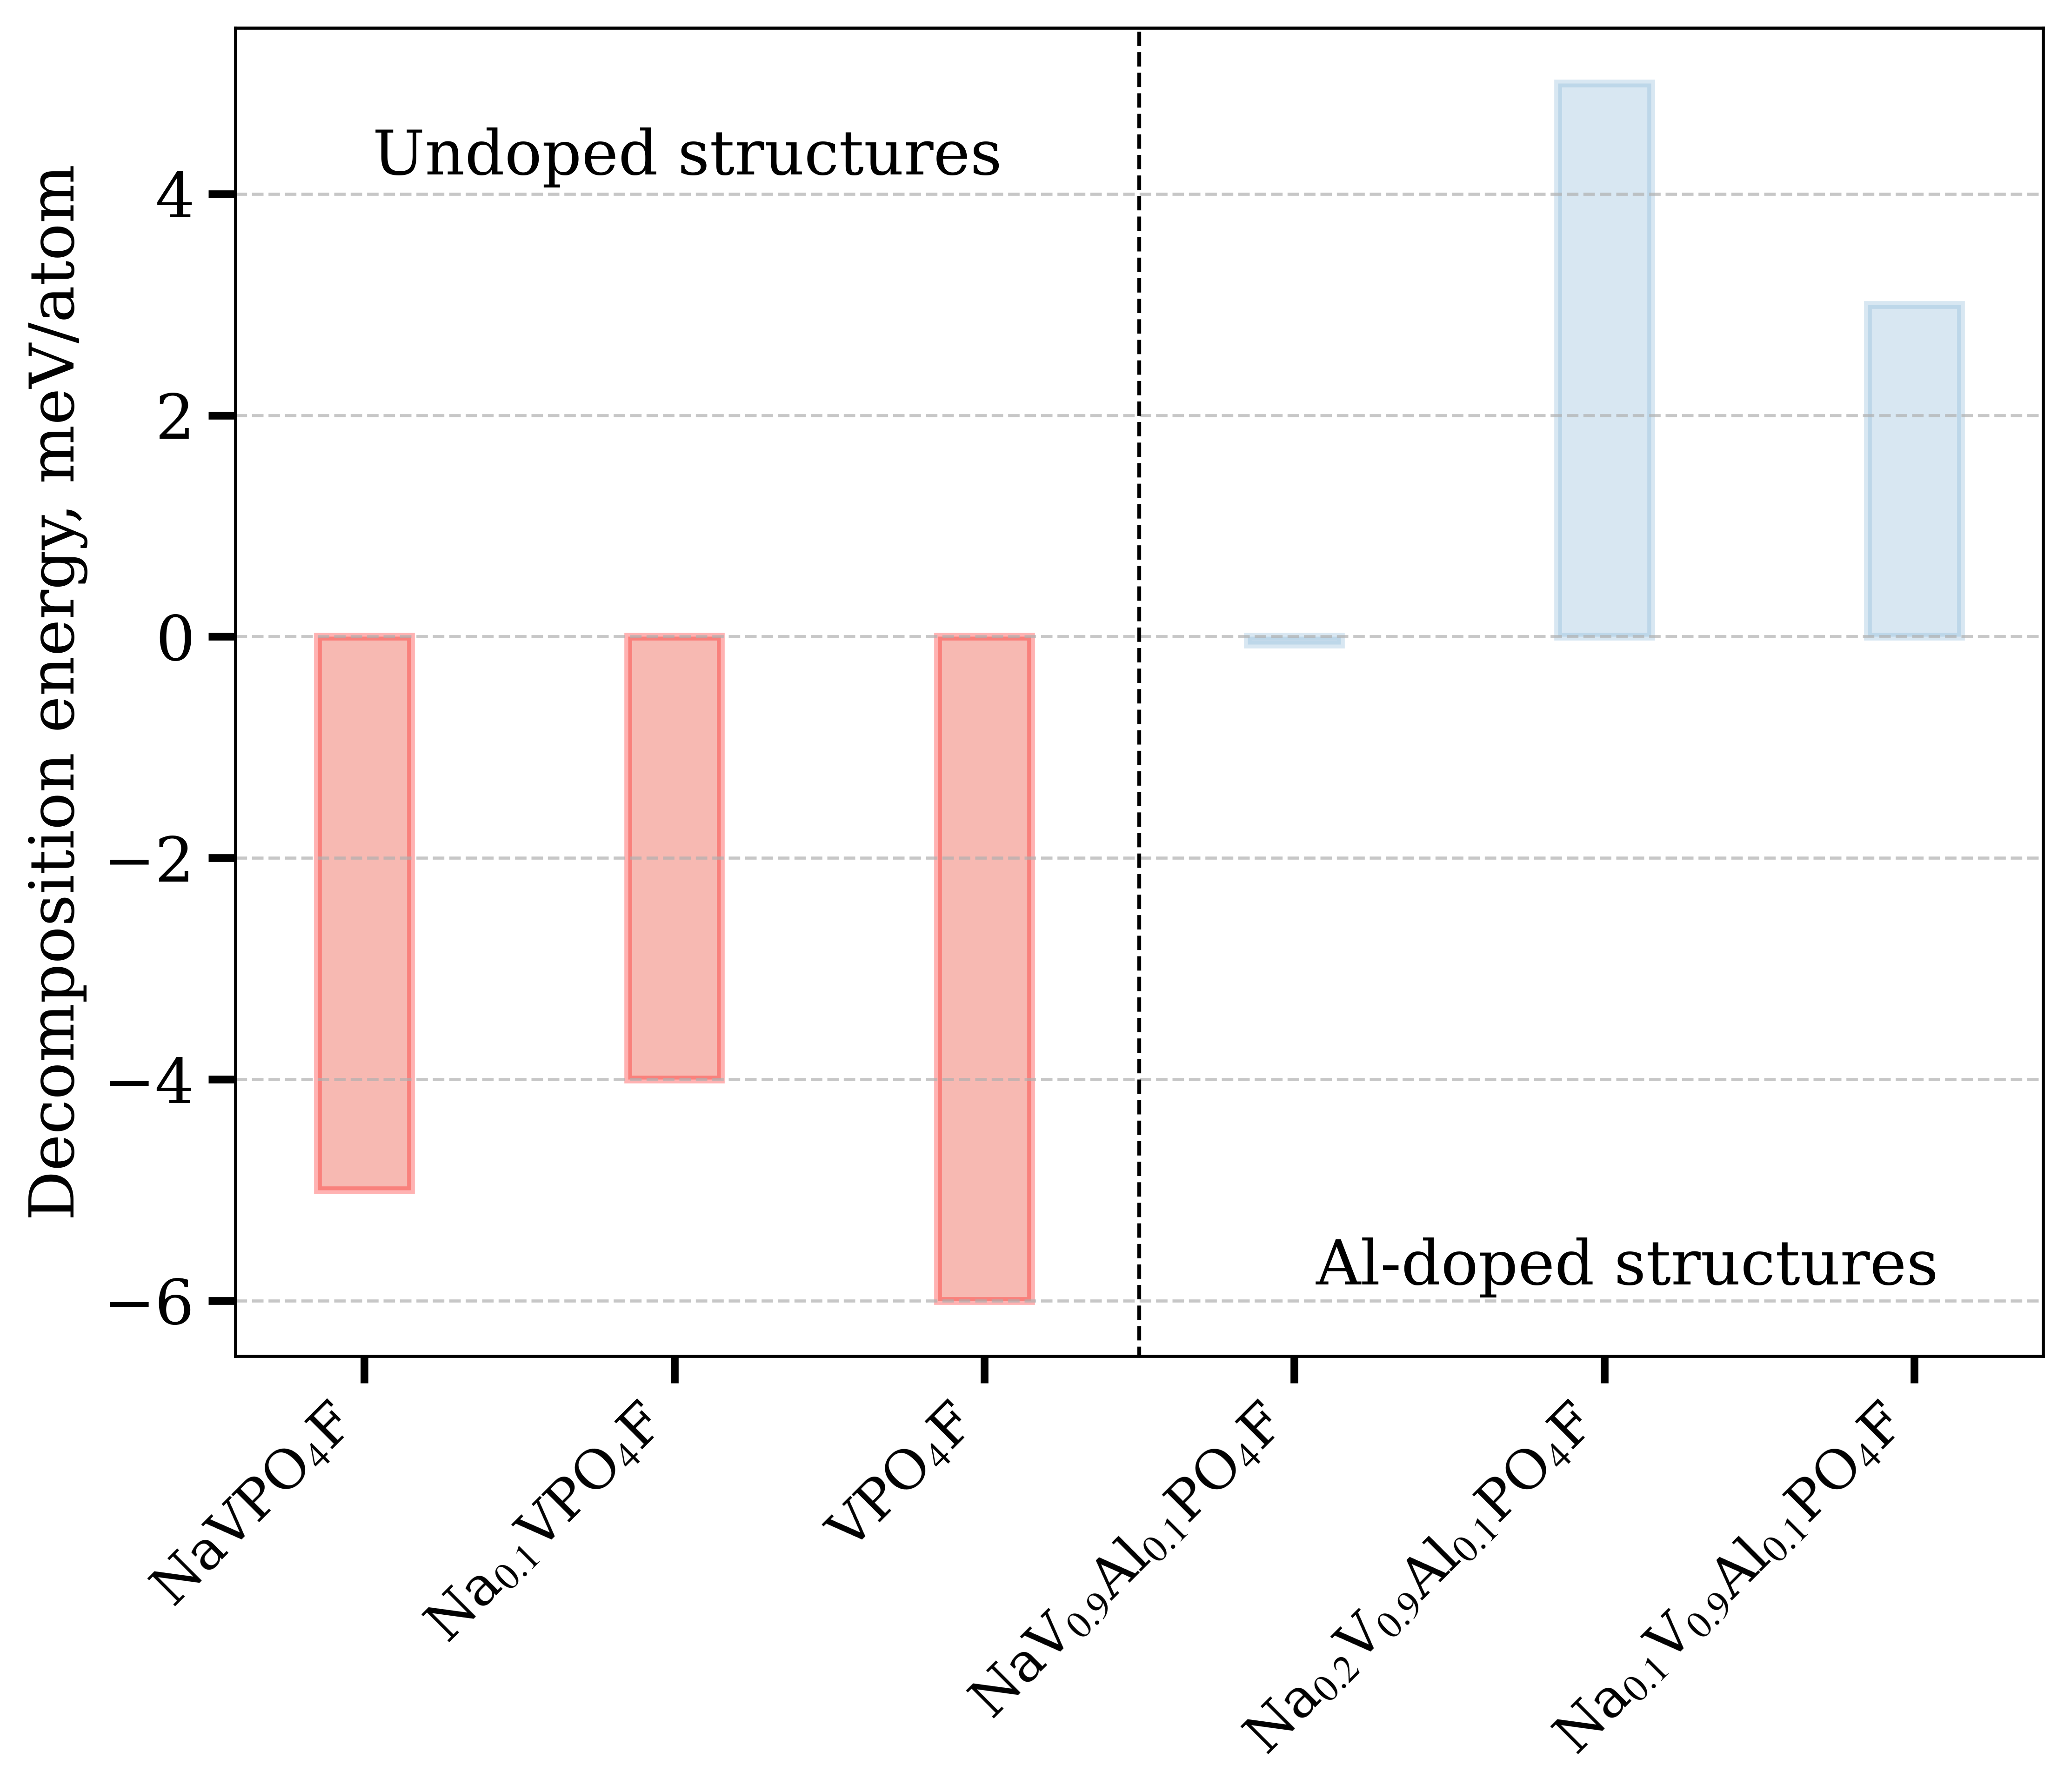

In [448]:
fontsize = 16
lw = 2.0
alpha = 0.3
width = 0.3

fig, ax = plt.subplots(1, 1, figsize=(8, 7), dpi=600)
plt.tight_layout()


# Add titles and labels
ax.set_ylabel(r'Decomposition energy, meV/atom', fontsize=fontsize)
# ax.set_xlabel('Antisite defect type', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize-2)
ax.yaxis.get_offset_text().set_fontsize(10)
ax.xaxis.set_tick_params(width=2, length=7)
ax.yaxis.set_tick_params(width=2, length=7)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=fontsize-2)
plt.grid(axis='y', linestyle='--', alpha=0.7)


# bp = ax.boxplot(data, patch_artist=True, showmeans=True, tick_labels=labels)
ax.bar(data_x[0:3],  data[0:3], width=width, color=colors_rgb["V"], alpha=alpha, edgecolor='r', linewidth=lw)
ax.bar(data_x[3:6],  data[3:6], width=width, color=colors_rgb["Al"], alpha=alpha, edgecolor=colors_rgb["Al"], linewidth=lw)

ax.set_label(labels)
        


ax.vlines(3.5, -18.0, 21, linestyles='--', color="black", lw=1)
ax.set_ylim([-6.5, 5.5], )
ax.text(0.25, 0.88, "Undoped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, ha='center', va='bottom', fontsize=fontsize, weight=400)
ax.text(0.77, 0.044, "Al-doped structures",  horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, ha='center', va='bottom', fontsize=fontsize, weight=400)

plt.tight_layout()
plt.show()


fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/decomp_energy.png", dpi=600, bbox_inches='tight')
fig.savefig("/home/arseniy/Desktop/work/nvpf_al_doped/figures/decomp_energy.pdf", dpi=600, bbox_inches='tight')



In [427]:
data_x[3:]

[4, 5, 6]

In [59]:
file = '/home/arseniy/Desktop/work/nvpf_al_doped/data/dos/al_some_na/vasprun.xml'

vasprun = Vasprun(file, parse_projected_eigen=True)



In [60]:
dos = vasprun.complete_dos

bandgap = dos.get_gap()
print(f"Band gap: {bandgap}")



Band gap: 1.4406999999999999
